# Capstone Project: Customer Response Prediction

Suthatta Dontriros (Fongnam)

## Background

A term deposit is an interest-bearing bank account and the bank makes revenue from this. Clients will invest for an agreed rate of interest over a fixed amount of time. The bank usually has various marketing plans to convince the customer to subscribe to a term deposit such as email marketing, advertisements, telemarketing, and digital marketing.

Telemarketing campaigns are one of the highly productive ways to contact people. However, the bank needs to spend more cost for telemarketing such as labour cost and phone bill for the large call centres investment. Hence, it is important to identify the customers most likely to subscribe to the campaign to reduce the cost ([*source*](https://www.kaggle.com/prakharrathi25/banking-dataset-marketing-targets?select=test.csv)).

## Problem Statement

The goal of this project is to develop the model that predicts the success of a bank marketing campaign based on the features in the dataset from UCI ([*source*](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#)). This model should therefore help the bank to identify potential customers who will be interested in the term deposit campaign.

## Dictionary

1. [Data Cleaning](#Data-Cleaning)
2. [EDA](#EDA)
3. [Modeling: Method 1](#Method-1-(All-features))
4. [Modeling: Method 2](#Method-2-(Feature-selection-and-more-feature-engineering))
5. [Modeling: Method 3](#Method-3-(PCA))
5. [Model Selection](#Model-Selection)
6. [Cost Benefit Analysis](#Cost-Benefit-Analysis)
7. [Conclusion & Recommendations](#Conclusion-and-Recommendations)

## Importing libraries

In [1]:
# Import the necessary functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score,roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix, confusion_matrix
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

## Data Cleaning

In [544]:
bank = pd.read_csv('data/bank-additional-full.csv', sep = ';')
pd.set_option('display.max_columns', None)
bank.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       226         1    999         0  nonexistent   
3   may         mon       151         1    999         0  nonexistent   
4   may         mon       307         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0           1.1          93.994          -36.4      4.857       5191.0  no  
1           1.1          93.994          -36.4      4.857       5191.0  no  
2           1.1          93.994          -36.4      4.857       5191.0  no  
3           1.1          93.994          -36.4      4.857       5191.0  no  
4           1.1          93.994          -36.4      4.857       5191.0  no

### Check missing value

In [545]:
def check_null_types(df):
    
    """This function takes input and shows the dataframe of missing values and data types
    parameters:
    df: dataframe"""
    
    return pd.DataFrame({'missing_values': df.isnull().sum(), 'types': df.dtypes})

In [546]:
check_null_types(bank)

missing_values    types
age                          0    int64
job                          0   object
marital                      0   object
education                    0   object
default                      0   object
housing                      0   object
loan                         0   object
contact                      0   object
month                        0   object
day_of_week                  0   object
duration                     0    int64
campaign                     0    int64
pdays                        0    int64
previous                     0    int64
poutcome                     0   object
emp.var.rate                 0  float64
cons.price.idx               0  float64
cons.conf.idx                0  float64
euribor3m                    0  float64
nr.employed                  0  float64
y                            0   object

### Statistical description

In [547]:
bank.describe()

age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198      1.734447     72.251528  
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000  
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000  
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000  
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000  
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

In [548]:
bank.rename(columns = {'y': 'target'}, inplace = True)
bank.head(1)

age        job  marital education default housing loan    contact month  \
0   56  housemaid  married  basic.4y      no      no   no  telephone   may   

  day_of_week  duration  campaign  pdays  previous     poutcome  emp.var.rate  \
0         mon       261         1    999         0  nonexistent           1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed target  
0          93.994          -36.4      4.857       5191.0     no

In [549]:
bank['target'] = bank['target'].map(lambda x: 1 if x == 'yes' else 0)

In [550]:
bank.shape

(41188, 21)

Dataset has 41,188 rows with 21 columns and it has no missing values. I observed that the class label in this data is column y, so I change the name of the column from 'y' to 'target' and convert the label to be an integer (no = 0, yes = 1). From the statistical description, the pdays column has the maximum value of 999 which should be converted to 0 because 999 means the client was not previously contacted.

### Create a list of continous and categortical variables based on data type

In [551]:
num_vars = []
cat_vars = []

for col in bank.columns: 
    if bank[col].dtype == 'O':
        cat_vars.append(col)
    else: 
        num_vars.append(col)

print(f'There are {len(cat_vars)} categorical variables: \n', cat_vars)
print('----' * 8)
print(f'There are {len(num_vars)} numerical variables: \n', num_vars)

There are 10 categorical variables: 
 ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
--------------------------------
There are 11 numerical variables: 
 ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'target']


### Check the number of unique values and the percent each value represents in categorical columns

In [552]:
for v in cat_vars:
    print(f'Unique values for {v}: {bank[v].nunique()}\n', 
          round(bank[v].value_counts(normalize=True)* 100, 2), '\n')

Unique values for job: 12
 admin.           25.30
blue-collar      22.47
technician       16.37
services          9.64
management        7.10
retired           4.18
entrepreneur      3.54
self-employed     3.45
housemaid         2.57
unemployed        2.46
student           2.12
unknown           0.80
Name: job, dtype: float64 

Unique values for marital: 4
 married     60.52
single      28.09
divorced    11.20
unknown      0.19
Name: marital, dtype: float64 

Unique values for education: 8
 university.degree      29.54
high.school            23.10
basic.9y               14.68
professional.course    12.73
basic.4y               10.14
basic.6y                5.56
unknown                 4.20
illiterate              0.04
Name: education, dtype: float64 

Unique values for default: 3
 no         79.12
unknown    20.87
yes         0.01
Name: default, dtype: float64 

Unique values for housing: 3
 yes        52.38
no         45.21
unknown     2.40
Name: housing, dtype: float64 

Unique valu

Dataset does not have a missing value but it has 'unknown' in the categorical column. Default column has the highest percentage of 'unknown' at 20.87% that shown in the below table. This table shows the percentage of 'unknown' in each categorical columns.

|Column name|% unknown|
|-----------|---------|
|job|0.8|
|marital|0.19|
|education|4.2|
|default|20.87|
|housing|2.4|
|loan|2.4|

For column named poutcome, it has 'nonexistent' about 86.34% which is the highest ratio when compared with other values in this column. I will not fix 'nonexistent' because this word occupies a large ratio and I choose to dummy this column.

### Fix the 'Unknown'

### Write functions that will fill 'unknown'

For the columns with the low ratio of 'unknown' (except column named default), the unknown in these columns are filled by other value in each column. The filling is randomly and bases on the ratio of each word in the column to conserve the same ratio, and this method does not change the data structure so much. 

In [553]:
def impute_values(variable, values, weight):
    
    """This function takes a variable and returns a randomly selected value
    if the variable is 'unknown'
    parameters:
    variable: variable in column
    values: list of variables without unknown
    weight: list of the probability of each variable"""
    
    if variable == 'unknown':
        return np.random.choice(values, p=weight)
    else: 
        return variable 

In [554]:
def fill_unknown(df, column):
    
    """This function takes a data frame and column name to fill 'unknown' with the other variable by weight.
    parameters:
    df: data frame
    column: list of the column that you want to fill 'unknown' by other variable"""
    
    for col in column:
        unique = list(set(df[col].values))
        unique.remove('unknown')
    
        weight = df[df[col] != 'unknown'][col].value_counts(normalize = True)
        weight = [i/sum(weight) for i in weight]
        print(df[col].value_counts(normalize = True))
    
        df[col] = df[col].map(lambda x: impute_values(x, unique, weight))
        print(df[col].value_counts(normalize = True))

In [555]:
# list of column name that I want to fill 'unknown' 

unknown_cols = ['job','marital', 'education', 'housing', 'loan']

In [556]:
try:
    fill_unknown(bank, unknown_cols)
except:
    pass

admin.           0.253035
blue-collar      0.224677
technician       0.163713
services         0.096363
management       0.070992
retired          0.041760
entrepreneur     0.035350
self-employed    0.034500
housemaid        0.025736
unemployed       0.024619
student          0.021244
unknown          0.008012
Name: job, dtype: float64
admin.           0.253278
blue-collar      0.224774
technician       0.165801
services         0.097771
management       0.071234
retired          0.042172
entrepreneur     0.037074
self-employed    0.035229
housemaid        0.025808
unemployed       0.025250
student          0.021608
Name: job, dtype: float64
married     0.605225
single      0.280859
divorced    0.111974
unknown     0.001942
Name: marital, dtype: float64
married     0.605735
single      0.282072
divorced    0.112193
Name: marital, dtype: float64
university.degree      0.295426
high.school            0.231014
basic.9y               0.146766
professional.course    0.127294
basic.4y       

In [557]:
# Recheck that functions work

bank['housing'].unique()

array(['no', 'yes'], dtype=object)

### Convert yes/no to integer
- yes = 1
- no = 0

In [558]:
nominal_yn = ['housing', 'loan']

for col in nominal_yn:
    bank[col] = bank[col].map({'no':0, 'yes':1})

In [559]:
bank['housing'].unique()

array([0, 1])

In [560]:
bank.head(2)

age        job  marital    education  default  housing  loan    contact  \
0   56  housemaid  married     basic.4y       no        0     0  telephone   
1   57   services  married  high.school  unknown        0     0  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  target  
0           1.1          93.994          -36.4      4.857       5191.0       0  
1           1.1          93.994          -36.4      4.857       5191.0       0

### Fix "999"

From the statistical description, I found that pdays column has '999' which means the client was not previously contacted from the previous campaign so I change 999 to be 0.

In [561]:
bank[bank['pdays'] == 999].head()

age        job  marital    education  default  housing  loan    contact  \
0   56  housemaid  married     basic.4y       no        0     0  telephone   
1   57   services  married  high.school  unknown        0     0  telephone   
2   37   services  married  high.school       no        1     0  telephone   
3   40     admin.  married     basic.6y       no        0     0  telephone   
4   56   services  married  high.school       no        0     1  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       226         1    999         0  nonexistent   
3   may         mon       151         1    999         0  nonexistent   
4   may         mon       307         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  target  
0           1.1          93.994          -36.4      4.857       5191.0       0  
1           1.1          93.994          -36.4      4.857       5191.0       0  
2           1.1          93.994          -36.4      4.857       5191.0       0  
3           1.1          93.994          -36.4      4.857       5191.0       0  
4           1.1          93.994          -36.4      4.857       5191.0       0

In [562]:
bank['pdays'] = bank['pdays'].map(lambda x: 0 if x == 999 else x)

### Drop duplicate rows

The dataset has 11 duplicate rows so I drop them and the total row after dropping is 41,177 rows.

In [563]:
bank.drop_duplicates(inplace = True)

In [564]:
bank.shape

(41177, 21)

## Data Dictionary

|Features        | Variable Type | Data Type | Description |
|----------------|---------------|-----------|-------------|
| age       | continuous         |int64| customer age|
|job| nominal | object|type of job|
|marital|nominal|object| marital status|
|education|ordinal|object| customer education|
|default|nominal|object|customer educcation|
|housing|nominal|int64|customer housing loan|
|loan|nominal|int64|customer personal loan|
|contact|nominal|object|contact communication type
|month|nominal|object|last contact month of year
|day_of_week|nominal|object|last contact day of the month|
|duration|continuous|int64|last contact duration, in seconds|
|campaign|discrete|int64|number of contacts performed during this campaign and for this client|
|pdays|discrete|int64|number of days that passed by after the client was last contacted from a previous campaign|
|previous|discrete|int64|number of contacts performed before this campaign and for this client|
|poutcome|nominal|object|outcome of the previous marketing campaign|
|emp.var.rate|continuous|float64|employment variation rate - quarterly indicator|
|cons.price.idx|continuous|float64|consumer price index - monthly indicator|
|cons.conf.idx|continuous|float64|consumer confidence index - monthly indicator|
|euribor3m|continuous|float64|euribor 3 month rate - daily indicator|
|nr.employed|continuous|float64|number of employees - quarterly indicator
|target|nominal|int64|customer respose to a term deposit|



## EDA

### Number of target

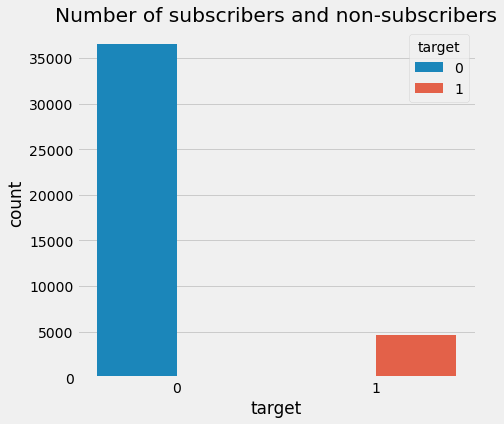

In [409]:
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
sns.countplot(x=bank['target'], data=bank, hue='target')
plt.title('Number of subscribers and non-subscribers');

From the barplot, it can be seen that out of 41,176 clients only 4,639 have actually subscribed to the term deposit. Therefore, further exploratory analysis is needed in order to better understand which segments of customers constitute our subscribers.

### Categorical data

In [26]:
# Create a dataframe with only the categroical variables

cat_data = bank[['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','target']]
cat_data.head()

job  marital    education  default  housing  loan    contact month  \
0  housemaid  married     basic.4y       no        0     0  telephone   may   
1   services  married  high.school  unknown        0     0  telephone   may   
2   services  married  high.school       no        1     0  telephone   may   
3     admin.  married     basic.6y       no        0     0  telephone   may   
4   services  married  high.school       no        0     1  telephone   may   

  day_of_week     poutcome  target  
0         mon  nonexistent       0  
1         mon  nonexistent       0  
2         mon  nonexistent       0  
3         mon  nonexistent       0  
4         mon  nonexistent       0

#### Create the graph to explore the importance of each column on the success rate

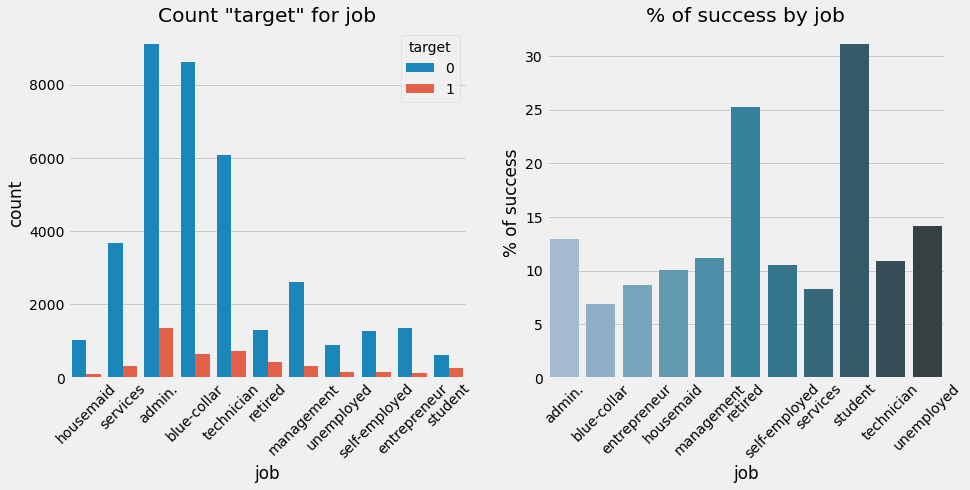

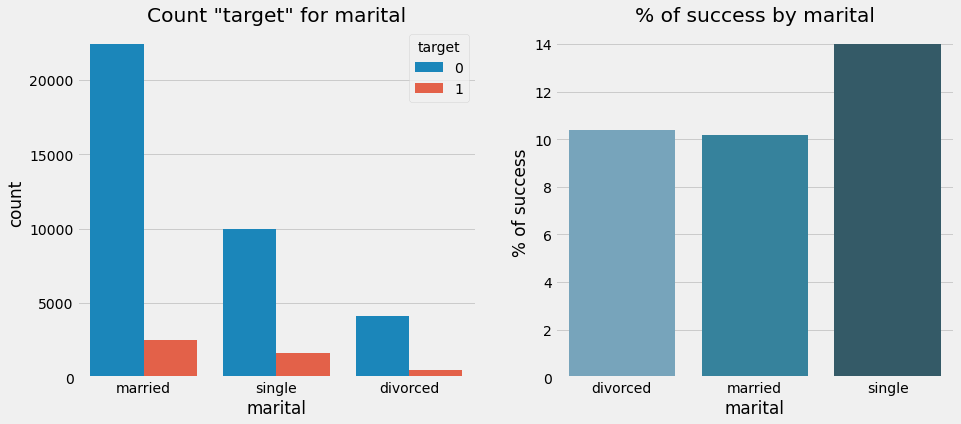

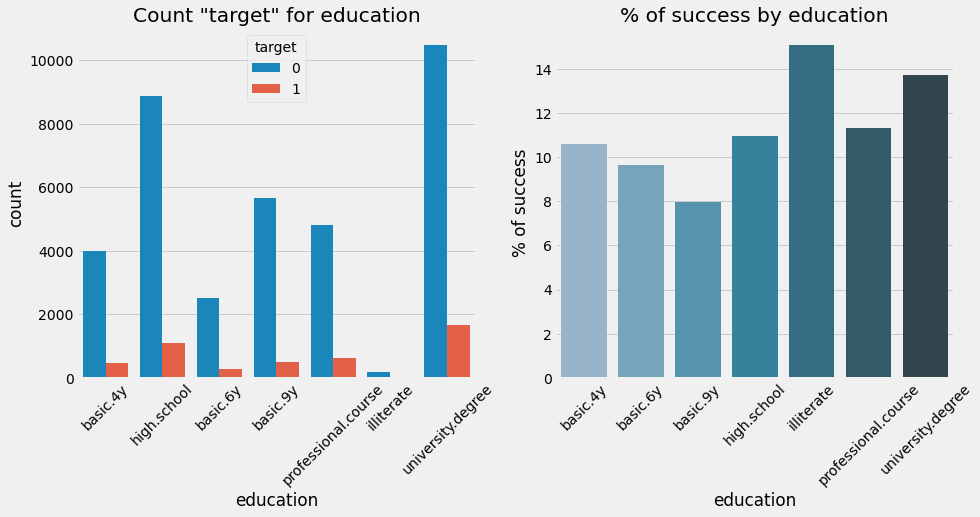

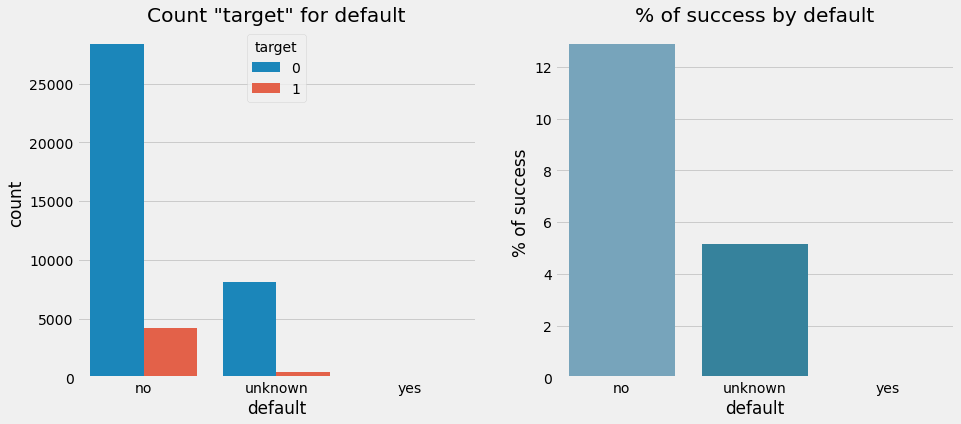

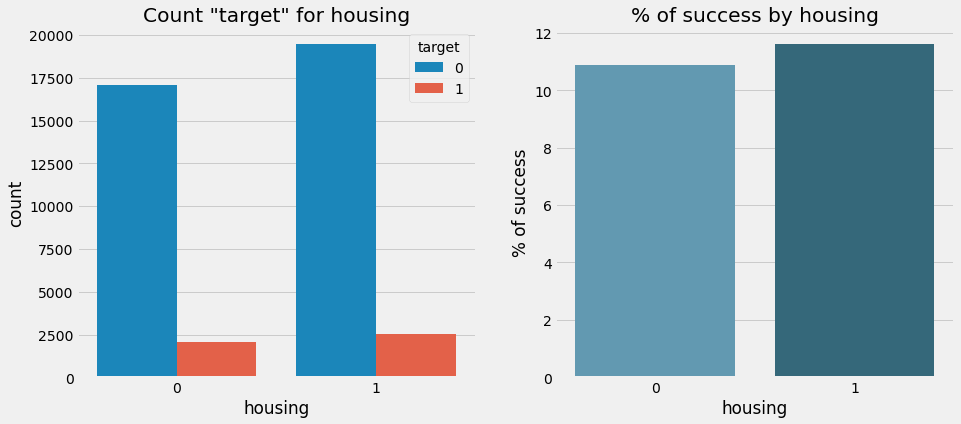

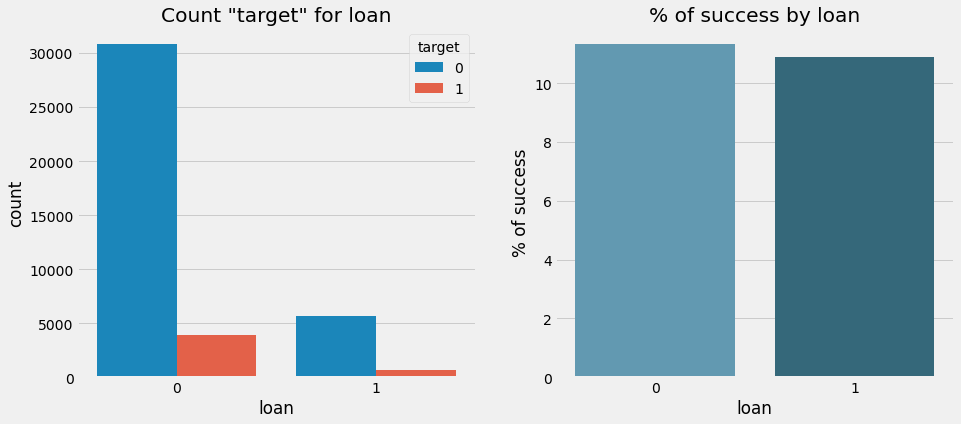

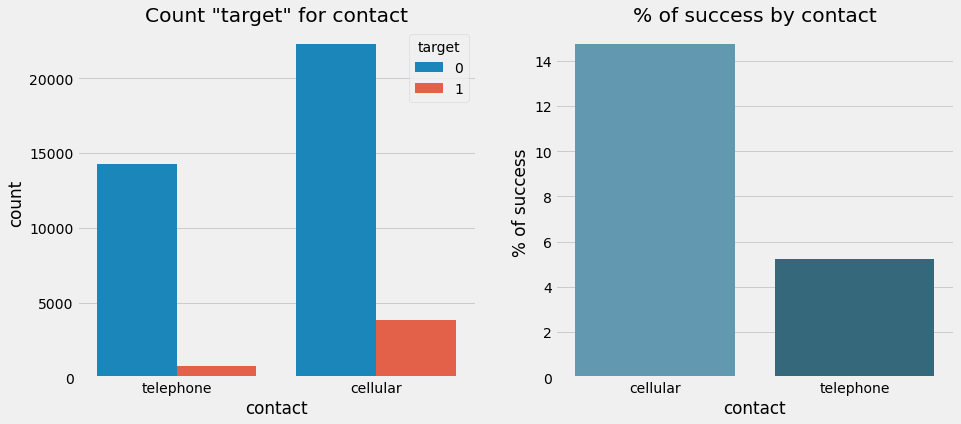

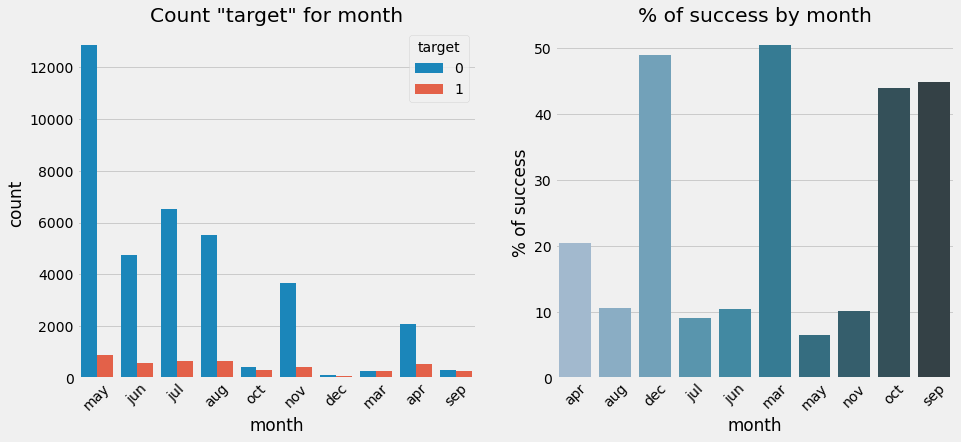

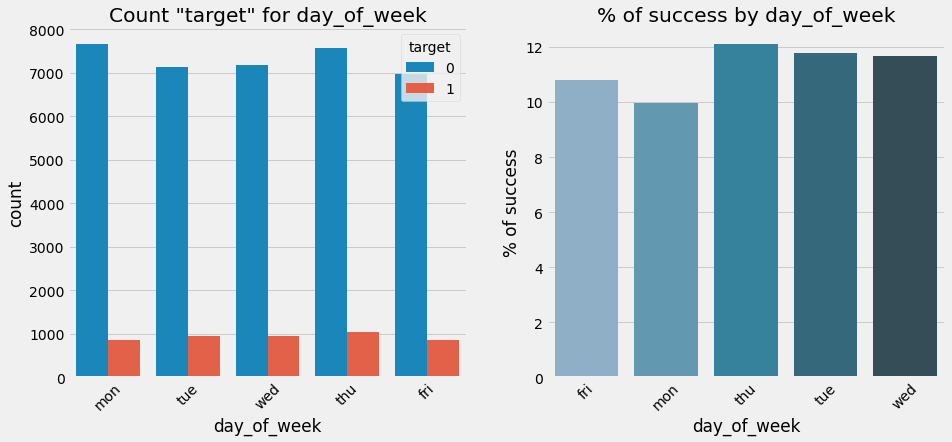

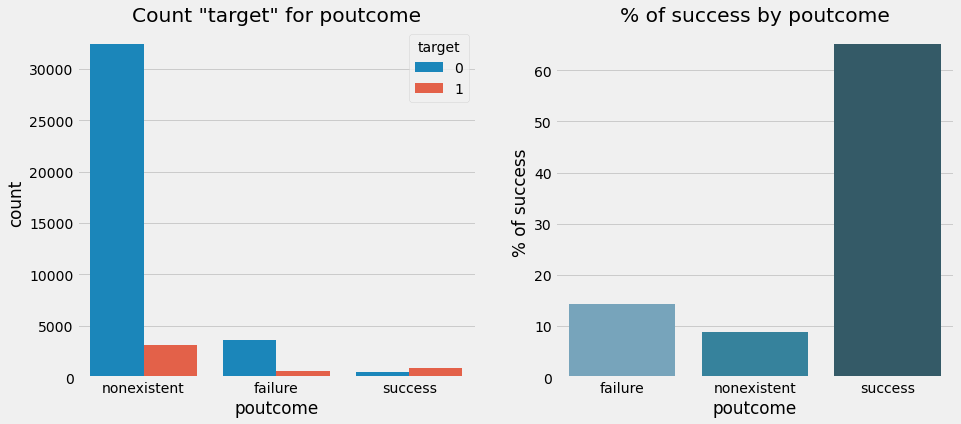

In [259]:
for col in cat_data.columns:
    if col != 'target':
        plt.figure(figsize=(14, 6))
        plt.subplot(1,2,1)
        sns.countplot(x=cat_data[col], data=cat_data, hue='target')
        plt.title(f'Count "target" for {col}')
        if cat_data[col].nunique() > 3:
                plt.xticks(rotation=45)
           
        plt.subplot(1,2,2)
        cat_percent = (cat_data.groupby(col)['target'].mean()*100)
        sns.barplot(x=cat_percent.index, y=cat_percent.values, palette='PuBuGn_d')
        plt.ylabel('% of success')
        plt.title(f'% of success by {col}')
        if cat_data[col].nunique() > 3:
                plt.xticks(rotation=45)       
    else:
        pass

**Interpretation:**
- **Job:** All jobs show a high unsuccess rate so it means no job appear to be much of a predictor of success for the bank marketing campaign. From the graph, students present the best success rate when compared with other jobs, and the retirees and admin give the percentage of success rate follow the student. This could be the business sign that the term deposit was well suited to them.
- **Marital:** Single people are interested in the campaign more than divorced and married people. The success rate of divorced and married people quite be the same level.
- **Education:** From the percent of success, the illiterate appears as a high percent of success but this group presents a very low number of the total count. It means the illiterate presents a high success rate because they are a small group. University educated people responded well and they are the largest group.
- **Default:** People with default are not interested in the campaign while people who have no default present the success rate at 12.5%.
- **Housing:** Housing loans seem like no significant impact on the campaign subscription.
- **Loan:** Personal loans also do not be presented as an important feature for the predictive model.
- **Contact:** Cellular phone presents the better success rate at 14.5%.
- **Month:** The success rate graph shows March, December, September and October present a high success rate, respectively. But all of these months have a very low total count. The graph on the left-hand side shows the majority of the campaign occurred between May and August.
- **Day of week:** No highlighted day on the graph because the success rate and success count seems the same. The middle week appears slightly more success rate.
- **Poutcome:** The outcome from the previous campaign does not have a strong relationship with the success rate in this campaign.

### Continuous data

#### Continuous data distribution

In [260]:
# create a dataframe of numerical data
num_data = bank[num_vars]
num_data.head(2)

age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0   56       261         1      0         0           1.1          93.994   
1   57       149         1      0         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  target  
0          -36.4      4.857       5191.0       0  
1          -36.4      4.857       5191.0       0

In [261]:
def plot_cont(df):
    
    """This function takes dataframe and plot the distribution for the numerical data
    parameters:
    df: dataframe"""
    
    fig = plt.figure(figsize=(15,30))
    plt.subplots_adjust(hspace=.25)

    nrows = len(df.columns) //2 +1 
    ncols = 2
    
    for i,t in enumerate(list(df.columns)):
        ax = fig.add_subplot(nrows, ncols, i+1)
        sns.distplot(a= df[t],   
                     ax=ax)
        plt.title(t + '_distribution')

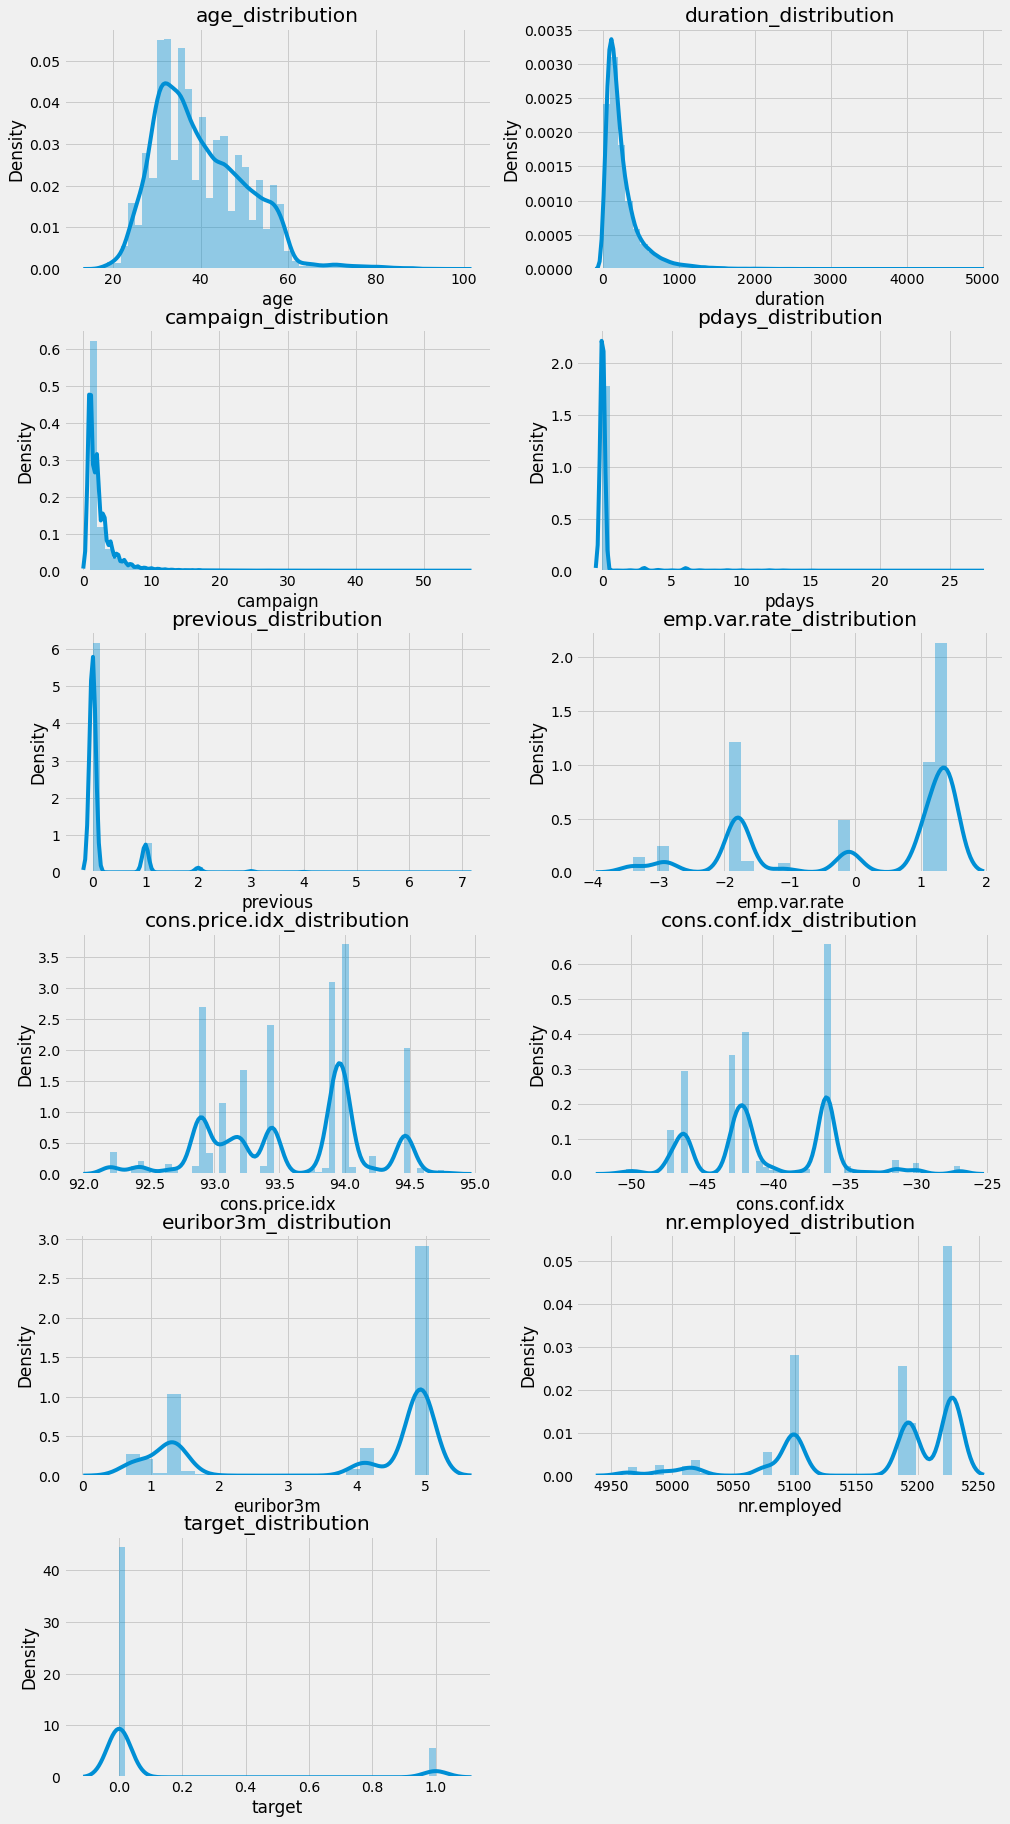

In [262]:
plot_cont(num_data)

**Interpretation:**
- All numerical features are not a normal distribution.
- The variables including age, duration, campaign, pdays and previous that have the positive skewness, while other variables have not patterned of distribution and there are similar shapes.

#### Outlier

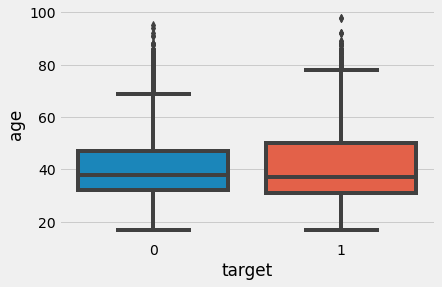

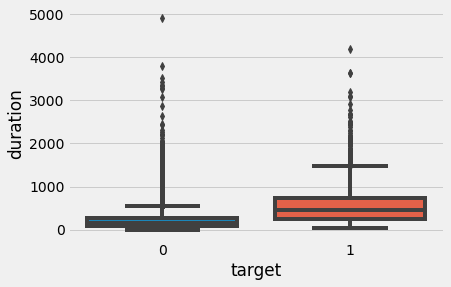

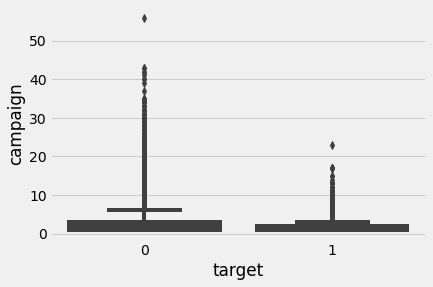

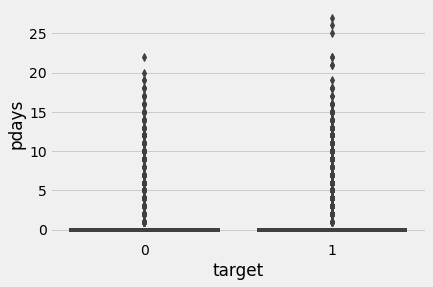

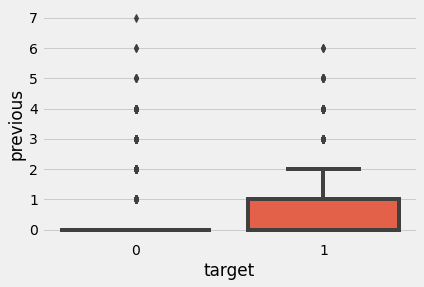

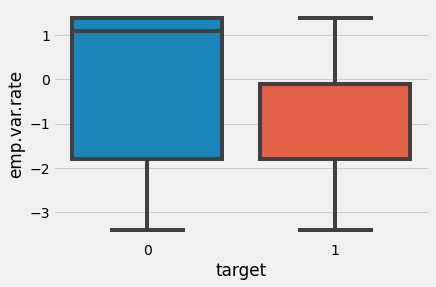

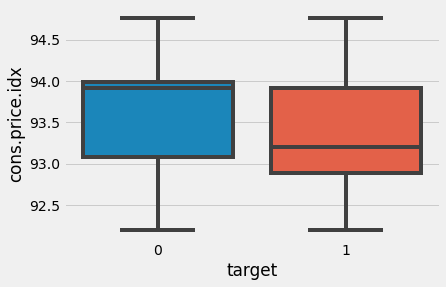

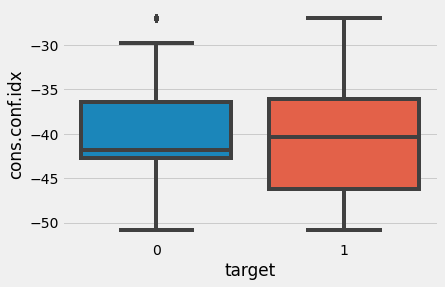

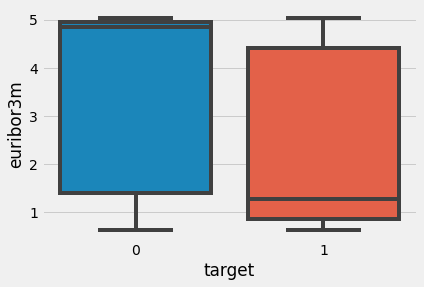

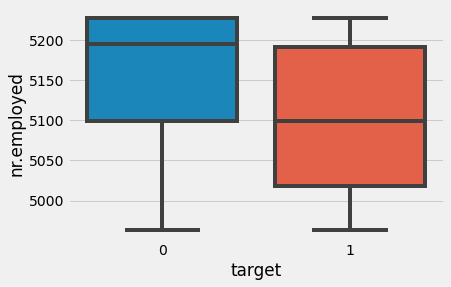

In [263]:
for col in cont_data:
    if col != 'target':
        sns.boxplot(x = 'target', y = col, data = bank)
        plt.show()

**Interpretation:**
- The outliers for age begin around 80.
- The duration has an outlier of about 1500.
- Campaign, pdays and previous are tightly clustered between 0 and 5.
- Other variables have no outliers.

#### Checking for correlations and multicollinearity

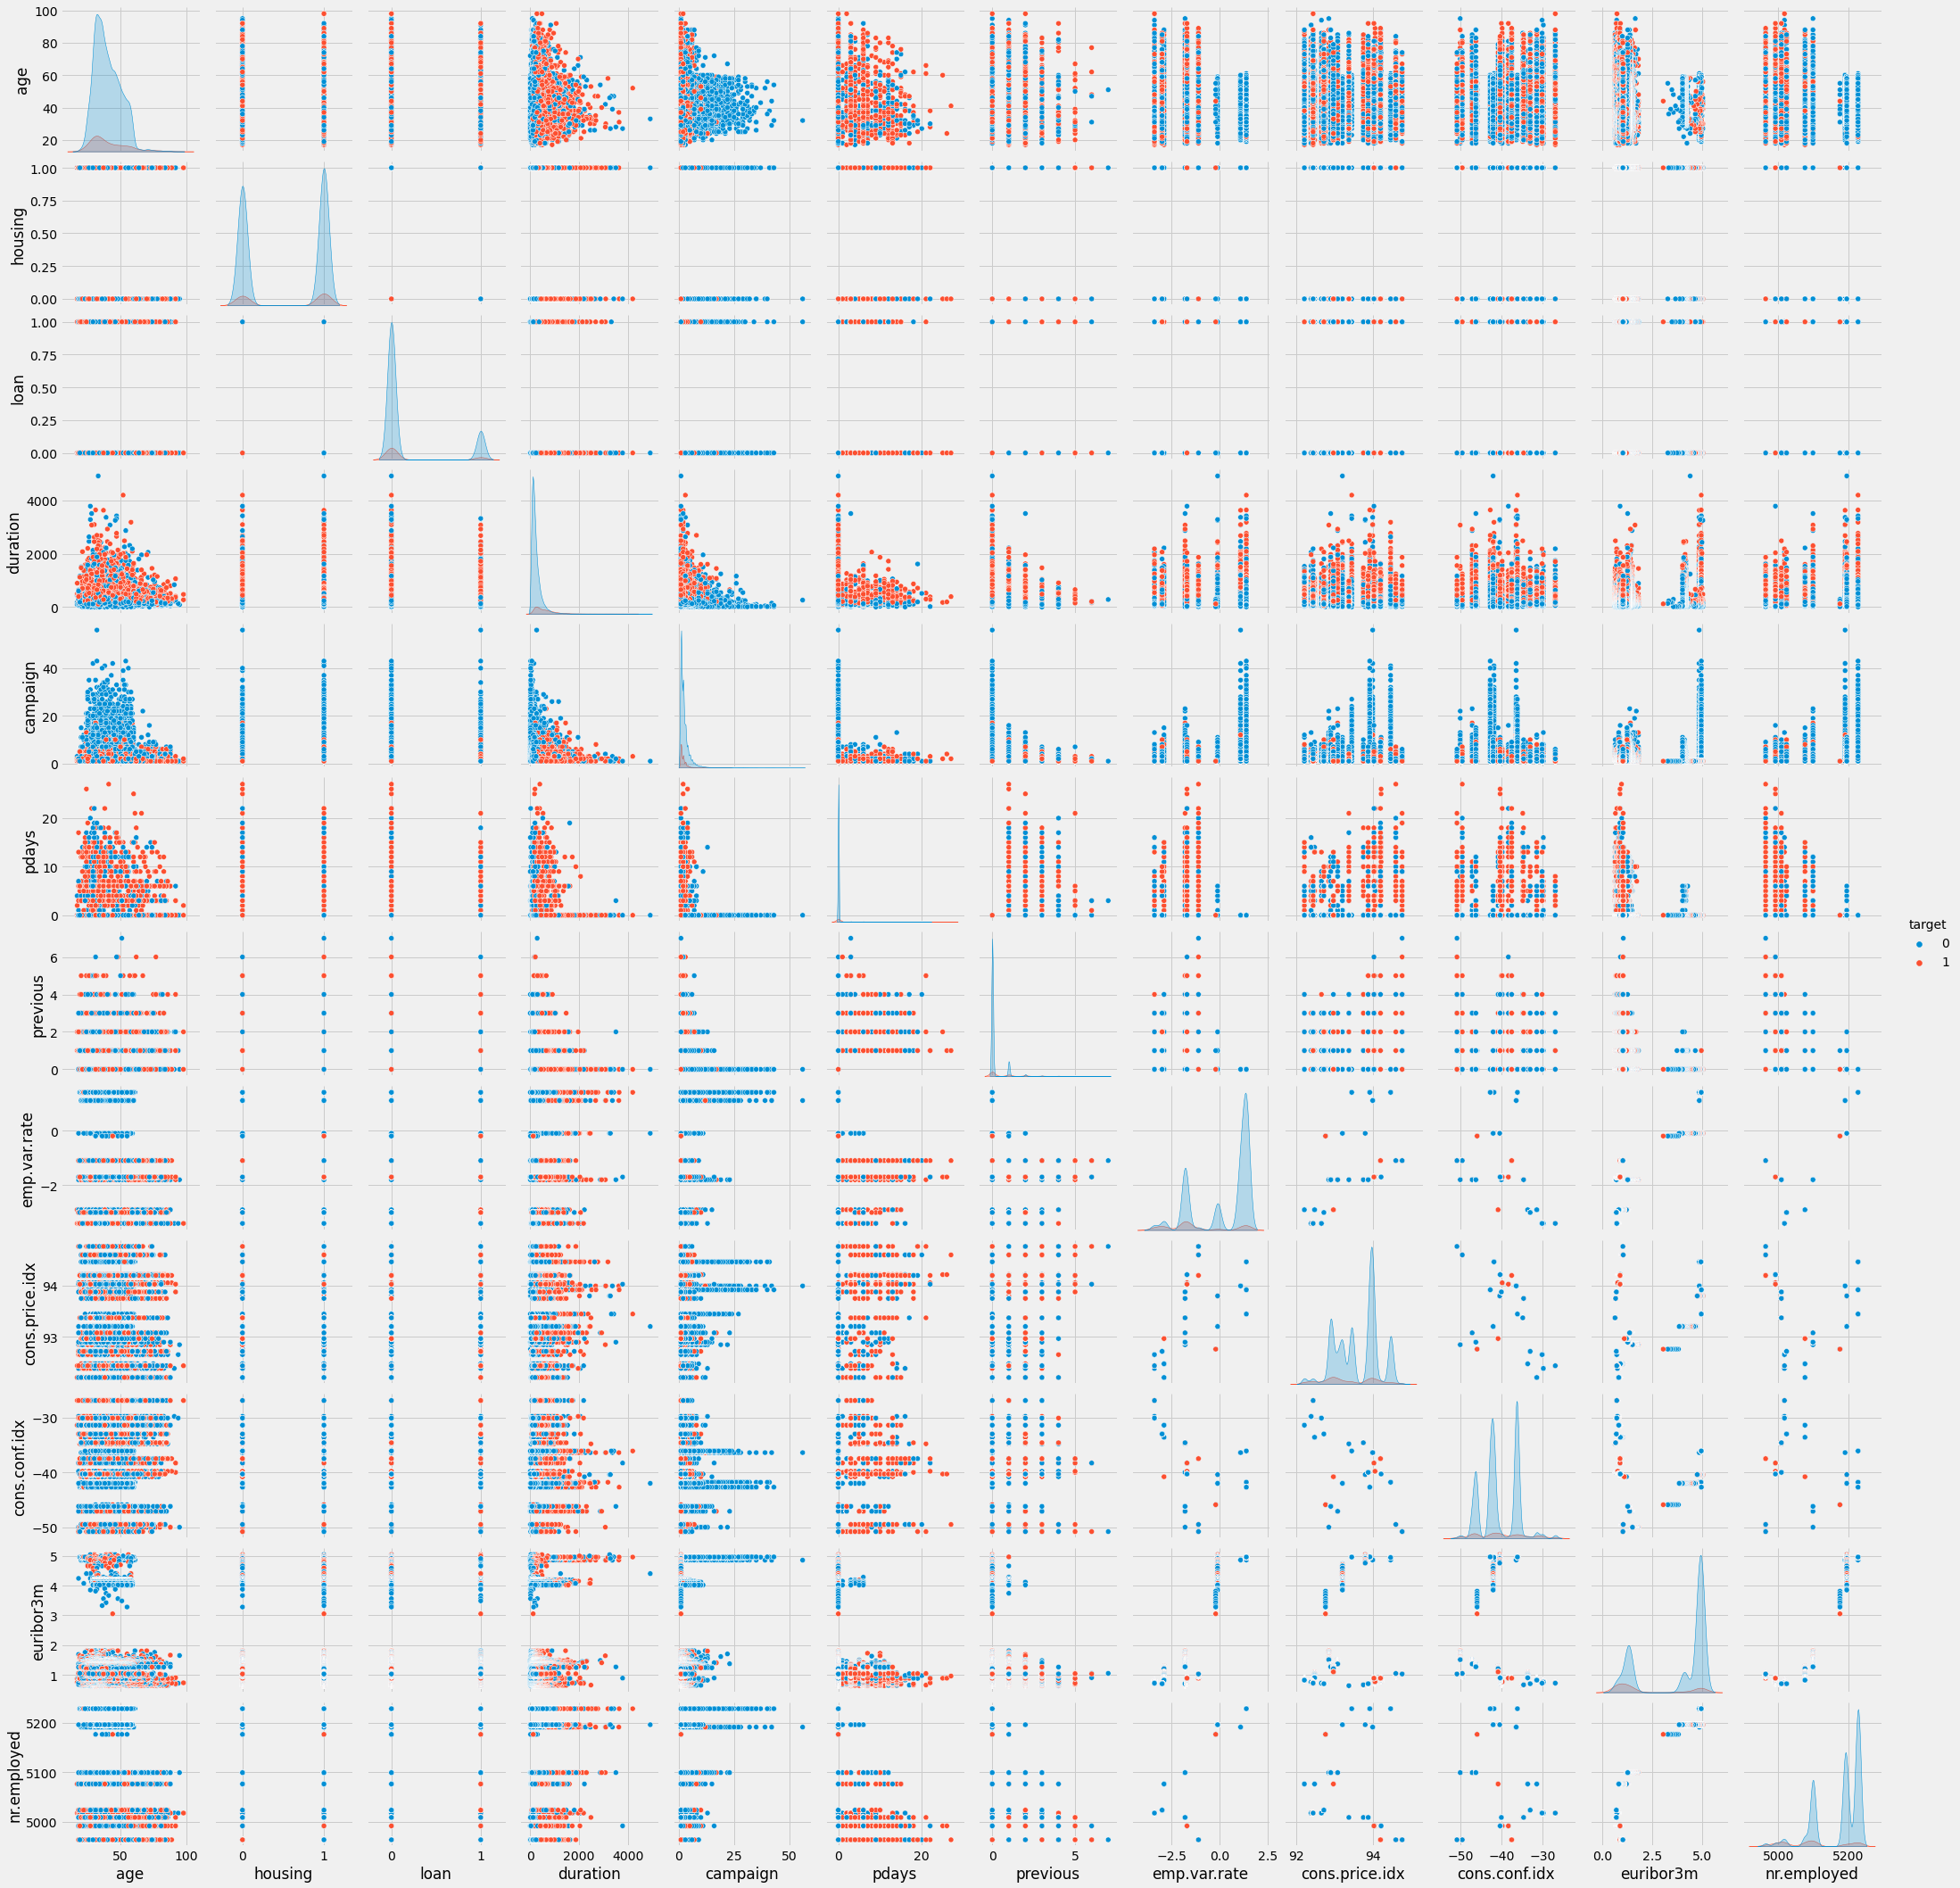

In [187]:
sns.pairplot(bank, hue = 'target')

The blue and red colour present an unsuccessful and successful case. No variables are highly correlated values in the dataset therefore it can assume that one variable changing will not impact other variables.

### Correlation heatmap

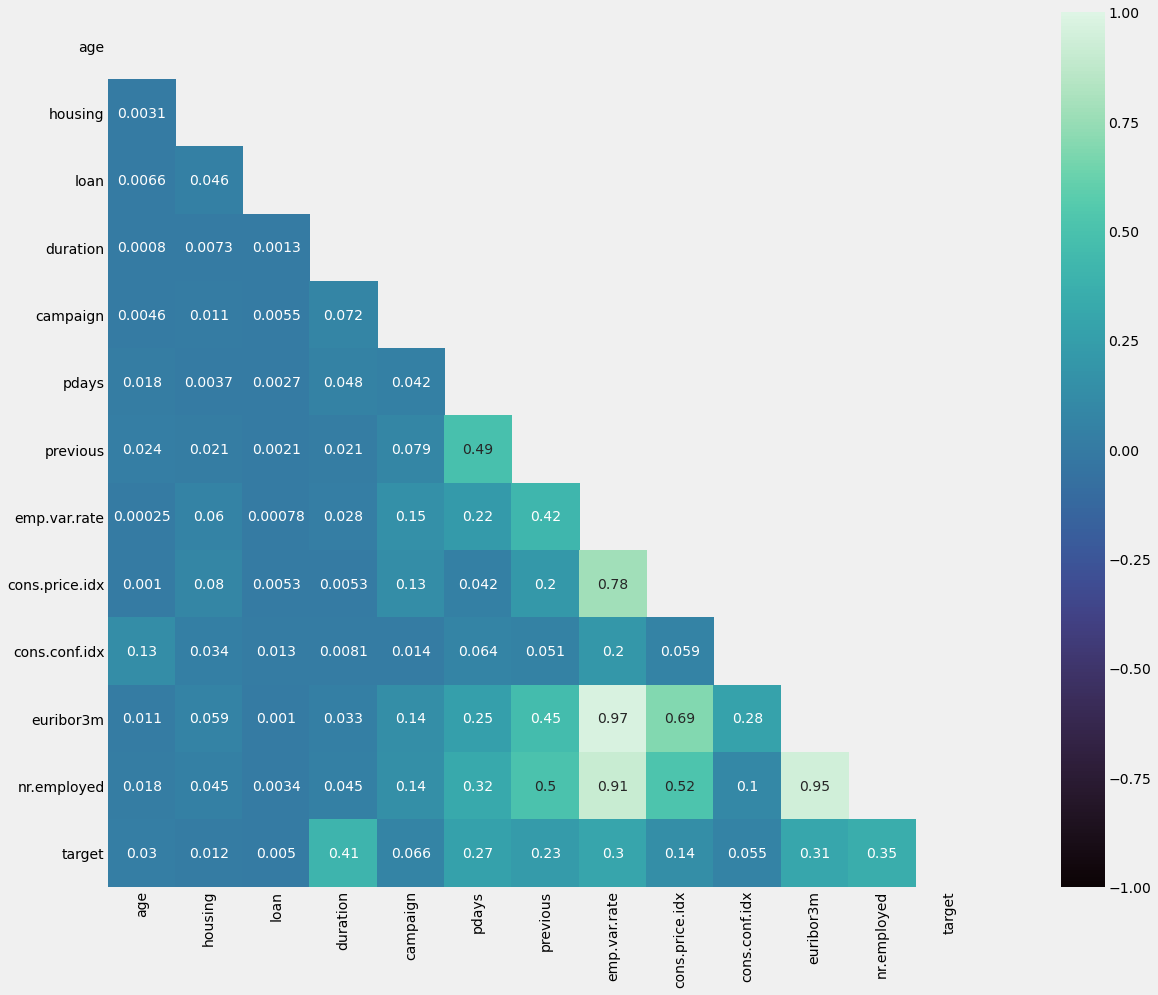

In [35]:
plt.figure(figsize = (25,15))
corr = bank.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(abs(corr), mask = mask, square = True, cmap = 'mako', annot = True, vmin = -1, vmax = 1);

From the correlation heatmap, the duration is the important feature for the predictive model. However, the duration will not be used in the predictive model because this feature will be recorded after bank staff finishes a call. The next important feature is the employment variation rate (0.3).

### How about the relationship between number of contact and success rate?

In [464]:
campaign = bank

In [468]:
campaign['campaign'] = campaign['campaign'].map(lambda x: '<5' if x<5 else '5-10' if 5<=x<=10 
                                                else '11-20' if 10<x<=20 else '20-30' if 20<x<=30 else '30-40' if 30<x<=40 else '>40')

In [475]:
campaign = campaign[['campaign', 'target']]

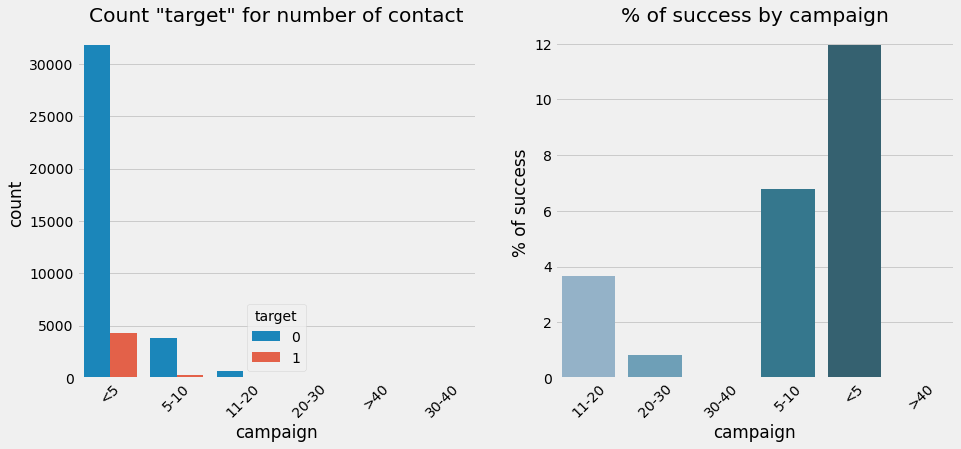

In [483]:
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
sns.countplot(x=campaign['campaign'], data=campaign, hue='target')
plt.title(f'Count "target" for number of contact')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
call_percent = (campaign.groupby('campaign')['target'].mean()*100)
sns.barplot(x=call_percent.index, y=call_percent.values, palette='PuBuGn_d')
plt.ylabel('% of success')
plt.title(f'% of success by campaign')
plt.xticks(rotation=45);

From the bar chart, the number of contact does not increase the success rate and a number of successful case. The customers who are contacted less than 5 times have more chance to agree with the campaign, while the customers who are contacted over 30 times tend to deny the campaign.

### Does age impact on success rate?

In [458]:
age = bank

In [460]:
age['age'] = age['age'].map(lambda x: '<20' if x<=20 else '20-35' if 20<x<=35 else '36-60' if 35<x<=60 else '>60')

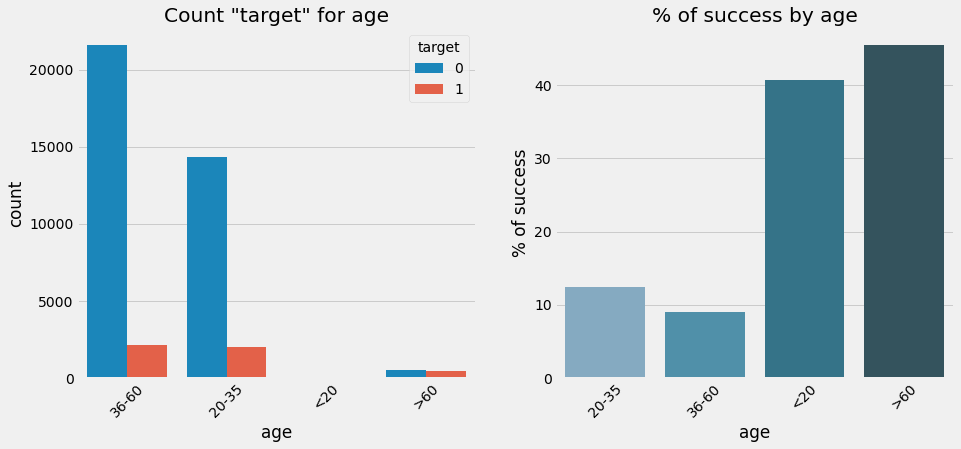

In [462]:
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
sns.countplot(x=age['age'], data=age, hue='target')
plt.title(f'Count "target" for age')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
age_percent = (age.groupby('age')['target'].mean()*100)
sns.barplot(x=age_percent.index, y=age_percent.values, palette='PuBuGn_d')
plt.ylabel('% of success')
plt.title(f'% of success by age')
plt.xticks(rotation=45);

I group age in 4 groups and found that the majority of the customer is people who in the range 36-60 years old, however, 36-60 years old does not give the high percentage of success rate. This is because the bank contacted this group more than other groups and get a high unsuccessful case, but the 36-60 and 20-35 years old are the interesting group if the bank counts the number of people who subscribe to the campaign. Let's focus on the success rate, the >60 and <20 years old present the high level of success rate because the bank contacts them less than the other groups and the difference between the unsuccessful case and the successful cases is not large.

### Does it have relationship between duration and the successful case?

<Figure size 1080x2880 with 0 Axes>

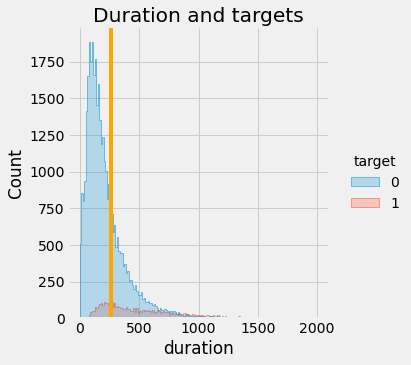

In [586]:
plt.figure(figsize=(15,40))
sns.displot(bank[bank['duration']<2000], x="duration", hue="target", element="step")
plt.axvline(x = bank['duration'].mean(), color = 'orange')
plt.title('Duration and targets');

From the graph, the successful case and the unsuccessful case have a similar shape and the duration with the highest count of the unsuccessful case lower than the successful case. This means people who denied the campaign took time to talk lesser than the successful case. The average duration is about 4.3 minutes.

## Modeling

## Method 1 (All features)

### Baseline

In [229]:
bank['target'].value_counts(normalize=True)

0    0.88734
1    0.11266
Name: target, dtype: float64

Since the original data is severely unbalanced with around 89% belonging to the negative class (0 = Unsuccessful case) and only 11% belonging to the positive class (1 = Successful case), using accuracy as the model evaluation metrics would be nonsensical since a model that predicts the majority class all the time would score extremely high accuracy. In this case, I expect to predict the successful case and, thus, I use ROCAUC as the evaluation metric. It measures how well predictions are ranked by probability and create a list of customers to contact. Moreover, I will also use False Positive and False Negative to help me with model selection because the bank wants to reduce the cost and the model should give a less incorrect prediction.

Our baseline score is a ROCAUC score of 0.5, meaning that the baseline model has no class separation capacity whatsoever.

### Feature Engineering

I get dummies from the 'job', 'education', 'contact', 'month', 'day_of_week', 'marital', 'poutcome', 'default' columns because these columns is nominal data.

#### Dummy

In [23]:
bank_dummy = pd.get_dummies(bank[['job', 'education', 'contact', 'month', 'day_of_week', 'marital', 'poutcome', 'default']], drop_first = True)
bank_dummy.head()

job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0                0                 0              1               0   
1                0                 0              0               0   
2                0                 0              0               0   
3                0                 0              0               0   
4                0                 0              0               0   

   job_retired  job_self-employed  job_services  job_student  job_technician  \
0            0                  0             0            0               0   
1            0                  0             1            0               0   
2            0                  0             1            0               0   
3            0                  0             0            0               0   
4            0                  0             1            0               0   

   job_unemployed  education_basic.6y  education_basic.9y  \
0               0                   0                   0   
1               0                   0                   0   
2               0                   0                   0   
3               0                   1                   0   
4               0                   0                   0   

   education_high.school  education_illiterate  education_professional.course  \
0                      0                     0                              0   
1                      1                     0                              0   
2                      1                     0                              0   
3                      0                     0                              0   
4                      1                     0                              0   

   education_university.degree  contact_telephone  month_aug  month_dec  \
0                            0                  1          0          0   
1                            0                  1          0          0   
2                            0                  1          0          0   
3                            0                  1          0          0   
4                            0                  1          0          0   

   month_jul  month_jun  month_mar  month_may  month_nov  month_oct  \
0          0          0          0          1          0          0   
1          0          0          0          1          0          0   
2          0          0          0          1          0          0   
3          0          0          0          1          0          0   
4          0          0          0          1          0          0   

   month_sep  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0          0                1                0                0   
1          0                1                0                0   
2          0                1                0                0   
3          0                1                0                0   
4          0                1                0                0   

   day_of_week_wed  marital_married  marital_single  poutcome_nonexistent  \
0                0                1               0                     1   
1                0                1               0                     1   
2                0                1               0                     1   
3                0                1               0                     1   
4                0                1               0                     1   

   poutcome_success  default_unknown  default_yes  
0                 0                0            0  
1                 0                1            0  
2                 0                0            0  
3                 0                0            0  
4                 0                0            0

In [24]:
bank_01 = pd.concat([bank.drop(columns = ['job', 'education', 'contact', 'month', 'day_of_week', 'marital', 'poutcome', 'default']), bank_dummy], axis = 1)
bank_01.head()

age  housing  loan  duration  campaign  pdays  previous  emp.var.rate  \
0   56        0     0       261         1      0         0           1.1   
1   57        0     0       149         1      0         0           1.1   
2   37        1     0       226         1      0         0           1.1   
3   40        0     0       151         1      0         0           1.1   
4   56        0     1       307         1      0         0           1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  target  \
0          93.994          -36.4      4.857       5191.0       0   
1          93.994          -36.4      4.857       5191.0       0   
2          93.994          -36.4      4.857       5191.0       0   
3          93.994          -36.4      4.857       5191.0       0   
4          93.994          -36.4      4.857       5191.0       0   

   job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0                0                 0              1               0   
1                0                 0              0               0   
2                0                 0              0               0   
3                0                 0              0               0   
4                0                 0              0               0   

   job_retired  job_self-employed  job_services  job_student  job_technician  \
0            0                  0             0            0               0   
1            0                  0             1            0               0   
2            0                  0             1            0               0   
3            0                  0             0            0               0   
4            0                  0             1            0               0   

   job_unemployed  education_basic.6y  education_basic.9y  \
0               0                   0                   0   
1               0                   0                   0   
2               0                   0                   0   
3               0                   1                   0   
4               0                   0                   0   

   education_high.school  education_illiterate  education_professional.course  \
0                      0                     0                              0   
1                      1                     0                              0   
2                      1                     0                              0   
3                      0                     0                              0   
4                      1                     0                              0   

   education_university.degree  contact_telephone  month_aug  month_dec  \
0                            0                  1          0          0   
1                            0                  1          0          0   
2                            0                  1          0          0   
3                            0                  1          0          0   
4                            0                  1          0          0   

   month_jul  month_jun  month_mar  month_may  month_nov  month_oct  \
0          0          0          0          1          0          0   
1          0          0          0          1          0          0   
2          0          0          0          1          0          0   
3          0          0          0          1          0          0   
4          0          0          0          1          0          0   

   month_sep  day_of_week_mon  day_of_week_thu  day_of_week_tue  \
0          0                1                0                0   
1          0                1                0                0   
2          0                1                0                0   
3          0                1                0                0   
4          0                1                0                0   

   day_of_week_wed  marital_married  marital_single  poutcome_nonexistent  \
0                

### Train-Test-Split

In [25]:
features_01 = bank_01.drop(columns = ['target', 'duration']).columns
X = bank_01[features_01]
y = bank_01['target']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size = 0.1, random_state = 42)

In [27]:
X_train.shape

(37059, 47)

In [28]:
X_test.shape

(4118, 47)

In [29]:
y_train.shape

(37059,)

In [30]:
y_test.shape

(4118,)

In [32]:
y_train.value_counts()

0    32884
1     4175
Name: target, dtype: int64

From the train data, the class label is the imbalanced data (0=32,884, 1=4175) therefore it needs the oversampling to solve this issue.

### Model

I choose 4 models (Logistic Regression, Decision Tree, Random Forest and XGBoost). I will scale data by using StandardScaler() and then in the GridSearchCV will make oversampling on the data to manage the imbalanced data.

#### StandardScaler

In [31]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### A. Logistic Regression

In [33]:
pipe_lr = Pipeline([('sm', SMOTE(random_state = 42)),
                       ('lr', LogisticRegression(random_state = 42))])

In [34]:
pipe_lr_params = {'lr__penalty': ['l1','l2'],
                  'lr__C': [.01,.1,1], 
                  'sm__k_neighbors': [3,5]}

In [35]:
gs_lr = GridSearchCV(pipe_lr,
                     param_grid = pipe_lr_params,
                     cv=5, 
                     n_jobs= -1,
                     scoring='roc_auc',
                     verbose=10)

In [36]:
gs_lr.fit(X_train_sc, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.01, 0.1, 1], 'lr__penalty': ['l1', 'l2'],
                         'sm__k_neighbors': [3, 5]},
             scoring='roc_auc', verbose=10)

In [38]:
lr_coef = pd.DataFrame(sorted(list(zip(X_train.columns,np.exp(gs_lr.best_estimator_.steps[1][1].coef_[0]))),key=lambda row : row[1],reverse=True),columns=['Feature','Exp(coef)'])
lr_coef.head(10)

Feature  Exp(coef)
0        cons.price.idx   3.296252
1           nr.employed   1.601746
2             euribor3m   1.418982
3      poutcome_success   1.360412
4  poutcome_nonexistent   1.182227
5             month_mar   1.179286
6         cons.conf.idx   1.169318
7             month_aug   1.136068
8       marital_married   1.085951
9        marital_single   1.082841

**Interpretation:** 

From the coefficient value, the most important factors affecting the campaign subscription includes consumer price index, number of employees and euribor 3-month rate. In fact, an increase of one unit of the consumer price index results in the increasing of chance that the customer will be the successful case 3.29 times. 

### Evaluation

In [37]:
print('Best parameters: ', gs_lr.best_params_)
print('Best estimator\'s CV AUC score: ', gs_lr.best_score_) 
print('Training AUC score:', gs_lr.score(X_train_sc, y_train))
print('Validation AUC score:', gs_lr.score(X_test_sc, y_test))

Best parameters:  {'lr__C': 0.1, 'lr__penalty': 'l2', 'sm__k_neighbors': 3}
Best estimator's CV AUC score:  0.7900981739848314
Training AUC score: 0.7941292600299948
Validation AUC score: 0.7920158352679161


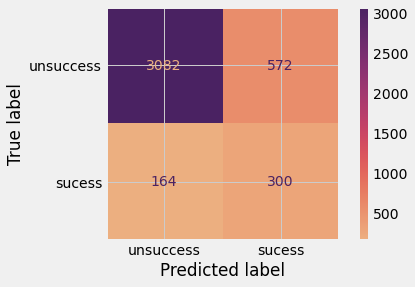

In [39]:
plot_confusion_matrix(gs_lr,X_test_sc,y_test,cmap='flare',display_labels=['unsuccess','sucess']);

In [184]:
def evaluation(y_test, y_pred):
    
    """This function takes input and prints accuracy, misclassification, sensitivity, specificity and precision results
    parameters:
    y_test: target data
    y_pred: result from prediction"""
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = round(((tp+tn)/(tp+tn+fp+fn)),3)
    missclassification = round(((fp+fn)/(tp+tn+fp+fn)),3)
    sensitivity = round((tp/(tp+fn)),3)
    specificity = round((tn/(tn+fp)),3)
    precision = round((tp/(tp+fp)),3)

    print(f'Accuracy is {accuracy}')
    print(f'Misclassification rate is {missclassification}')
    print(f'Sensitivity is {sensitivity}')
    print(f'Specificity is {specificity}')
    print(f'Precision is {precision}')

In [185]:
evaluation(y_test, gs_lr.predict(X_test_sc))

Accuracy is 0.821
Misclassification rate is 0.179
Sensitivity is 0.647
Specificity is 0.843
Precision is 0.344


|     Method           | Model |Training AUC score |CV AUC score|Validation AUC score|
|----------------|---------------|-----------|-----------|---------|
|All features|Logistic Regression|0.794|0.790|0.792|

- The Logistic Regression model built has a relatively good ROCAUC score on training data at 0.794 which is slightly higher than the testing data and the cross-validation set. 
- The confusion matrix above shows that the model correctly classed that samples have 'unsuccess' 3082 cases. However, the model predicts incorrect result at 164 and 572 for False Negative and False Positive which are quite high.
- The sensitivity is 0.647 which means this model can predict successful case 64.7% of all successful cases.

### B. Decision Tree

In [41]:
pipe_dt = Pipeline([('sm', SMOTE(random_state = 42)),
                    ('dt', DecisionTreeClassifier(random_state = 42))])

In [42]:
pipe_dt_params = {
    'sm__k_neighbors': [3,5],
    'dt__max_depth': [3,5],
    'dt__min_samples_split': [5,7]
}

In [43]:
gs_dt = GridSearchCV(pipe_dt,
                     param_grid=pipe_dt_params,
                     cv=5, 
                     n_jobs=-1,
                     scoring='roc_auc',
                     verbose=10)

In [44]:
gs_dt.fit(X_train_sc, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'dt__max_depth': [3, 5],
                         'dt__min_samples_split': [5, 7],
                         'sm__k_neighbors': [3, 5]},
             scoring='roc_auc', verbose=10)

### Evaluation

In [45]:
print('Best parameters: ', gs_dt.best_params_)
print('Best CV AUC score: ', gs_dt.best_score_)
print('Training AUC score:', gs_dt.score(X_train_sc, y_train))
print('Validation AUC score:', gs_dt.score(X_test_sc, y_test))

Best parameters:  {'dt__max_depth': 5, 'dt__min_samples_split': 5, 'sm__k_neighbors': 3}
Best CV AUC score:  0.7544706044429046
Training AUC score: 0.7571771248890129
Validation AUC score: 0.7649322660098521


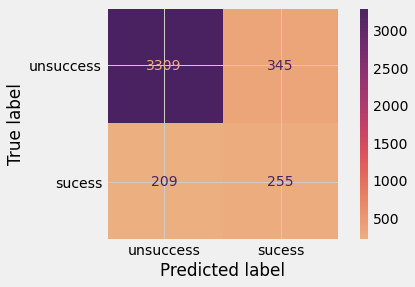

In [46]:
plot_confusion_matrix(gs_dt,X_test_sc,y_test,cmap='flare',display_labels=['unsuccess','sucess']);

In [186]:
evaluation(y_test, gs_dt.predict(X_test_sc))

Accuracy is 0.865
Misclassification rate is 0.135
Sensitivity is 0.55
Specificity is 0.906
Precision is 0.425


|     Method           | Model |Training AUC score |CV AUC score|Validation AUC score|
|----------------|---------------|-----------|-----------|---------|
|All features|Logistic Regression|0.794|0.790|0.792|
|All features|Decision Tree|0.757|0.754|0.764|

- The Decision Tree model built has a relatively good ROCAUC score on the validation set at 0.764 which is slightly higher than the training data and the cross-validation set. 
- The confusion matrix above shows that the model correctly classed that samples have 'unsuccess' 3309 cases. However, the model predicts incorrect result at 209 and 345 for False Negative and False Positive which is lower than the Logistic Regression result that I did earlier. 
- The sensitivity is 0.55 which means this model can predict successful case 55% of all successful cases.

### D. Random Forest

In [47]:
pipe_rf = Pipeline([('sm', SMOTE(random_state = 42)), 
                    ('rf', RandomForestClassifier(random_state = 42))])

In [48]:
pipe_rf_params = {
    'sm__k_neighbors':[3,5],
    'rf__n_estimators': [50,100],
    'rf__max_depth': [3,5], 
    'rf__min_samples_split': [2,4]}

In [49]:
gs_rf = GridSearchCV(pipe_rf,
                     param_grid=pipe_rf_params,
                     cv=5, 
                     n_jobs=-1,
                     scoring='roc_auc',
                     verbose=10)

In [50]:
gs_rf.fit(X_train_sc, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [3, 5],
                         'rf__min_samples_split': [2, 4],
                         'rf__n_estimators': [50, 100],
                         'sm__k_neighbors': [3, 5]},
             scoring='roc_auc', verbose=10)

### Evaluation

In [51]:
print('Best parameters: ', gs_rf.best_params_)
print('Best CV AUC score: ', gs_rf.best_score_)
print('Training AUC score:', gs_rf.score(X_train_sc, y_train))
print('Validation AUC score:', gs_rf.score(X_test_sc, y_test))

Best parameters:  {'rf__max_depth': 5, 'rf__min_samples_split': 4, 'rf__n_estimators': 50, 'sm__k_neighbors': 5}
Best CV AUC score:  0.7901911025587521
Training AUC score: 0.7951287814833781
Validation AUC score: 0.808542657550535


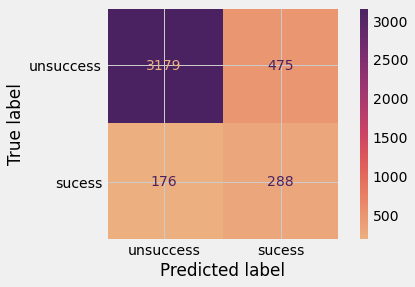

In [52]:
plot_confusion_matrix(gs_rf,X_test_sc,y_test,cmap='flare',display_labels=['unsuccess','sucess']);

In [187]:
evaluation(y_test, gs_rf.predict(X_test_sc))

Accuracy is 0.842
Misclassification rate is 0.158
Sensitivity is 0.621
Specificity is 0.87
Precision is 0.377


|     Method           | Model |Training AUC score |CV AUC score|Validation AUC score|
|----------------|---------------|-----------|-----------|---------|
|All features|Logistic Regression|0.794|0.790|0.792|
|All features|Decision Tree|0.757|0.754|0.764|
|All features|Random Forest|0.795|0.790|0.808|

- The Random Forest model built has a relatively good ROCAUC score on validation data at 0.808 which is slightly higher than the training data and the cross-validation set. 
- The confusion matrix above shows that the model correctly classed that samples have 'unsuccess' 3179 cases. However, the model predicts incorrect result at 176 and 475 for False Negative and False Positive which are high as the Decision Tree result. 
- The sensitivity is 0.621 which means this model can predict successful case 62.1% of all successful cases.

### G. XGBoost

In [655]:
pipe_xg = Pipeline([('sm', SMOTE(random_state = 42)), 
                    ('xg', XGBClassifier(random_state = 42))])

In [656]:
pipe_xg_params = {
    'xg__learning_rate': [0.01, 0.1, 0.2],
    'xg__max_depth': [3,5],
    'xg__min_child_weight': [2,4],
    'sm__k_neighbors': [3,5]
}

In [657]:
gs_xg = GridSearchCV(pipe_xg,
                     param_grid=pipe_xg_params,
                     cv=5, 
                     n_jobs=-1,
                     scoring='roc_auc',
                     verbose=10)

In [658]:
gs_xg.fit(X_train_sc, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[07:19:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('xg',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                 

In [660]:
print('Best parameters: ', gs_xg.best_params_)
print('Best CV AUC score: ', gs_xg.best_score_)
print('Training AUC score:', gs_xg.score(X_train_sc, y_train))
print('Validation AUC score:', gs_xg.score(X_test_sc, y_test))

Best parameters:  {'sm__k_neighbors': 5, 'xg__learning_rate': 0.1, 'xg__max_depth': 5, 'xg__min_child_weight': 4}
Best CV AUC score:  0.7933044101642108
Training AUC score: 0.8273567983847412
Validation AUC score: 0.7985878135439669


### Evaluation

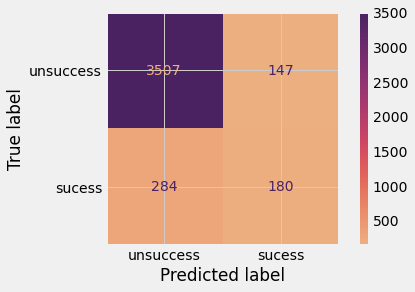

In [661]:
plot_confusion_matrix(gs_xg,X_test_sc,y_test,cmap='flare',display_labels=['unsuccess','sucess']);

In [663]:
evaluation(y_test, gs_xg.predict(X_test_sc))

Accuracy is 0.895
Misclassification rate is 0.105
Sensitivity is 0.388
Specificity is 0.96
Precision is 0.55


|     Method           | Model |Training AUC score |CV AUC score|Validation AUC score|
|----------------|---------------|-----------|-----------|---------|
|All features|Logistic Regression|0.794|0.790|0.792|
|All features|Decision Tree|0.757|0.754|0.764|
|All features|Random Forest|0.795|0.790|0.808|
|All features|XGBoost|0.827|0.793|0.798|

- The XGBoost model built has a relatively good ROCAUC score on training data at 0.827 which is slightly higher than the testing data and the cross-validation set. The ROCAUC score shows this model is overfitting. 
- The confusion matrix above shows that the model correctly classed that samples have 'unsuccess' 3507 cases. However, the model predicts incorrect result at 284 and 147 for False Negative and False Positive which is the lowest value when compared to other models. 
- The sensitivity is 0.388 which means this model can predict successful case 38.8% of all successful cases.

## Model Evaluation/Comparison

In [191]:
def plot_evaluation(y_test, y_pred1, y_pred2, y_pred3, y_pred4):
    
    """This function takes inputs and plot the barchart of classification metrics on validation set.
    parameters:
    y_test: testing data
    y_pred1: predicted result from model 1
    y_pred2: predicted result from model 2
    y_pred3: predicted result from model 3
    y_pred4: predicted result from model 4
    """
    l_perf = (confusion_matrix(y_test, y_pred1)).ravel()
    dt_perf = (confusion_matrix(y_test, y_pred2)).ravel()
    rf_perf = (confusion_matrix(y_test, y_pred3)).ravel()
    xg_perf = (confusion_matrix(y_test, y_pred4)).ravel()
    #tn, fp, fn, tp
    l_perf = [l_perf[3],l_perf[1],l_perf[0],l_perf[2]]
    dt_perf = [dt_perf[3],dt_perf[1],dt_perf[0],dt_perf[2]]
    rf_perf = [rf_perf[3],rf_perf[1],rf_perf[0],rf_perf[2]]
    xg_perf = [xg_perf[3],xg_perf[1],xg_perf[0],xg_perf[2]]
    
    ind = np.arange(4)  # the x locations for the groups
    width = 0.20       # the width of the bars

    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot(111)
    rects1 = ax.barh(ind, l_perf[::-1], width, color='#69b1b3')
    rects2 = ax.barh(ind+width, dt_perf[::-1], width, color='#e27071')
    rects3 = ax.barh(ind+2*width,rf_perf[::-1], width, color='#76c474')
    rects4 = ax.barh(ind+3*width, xg_perf[::-1], width, color='purple')

    #['#69b1b3','#76c474','#ebdf6a','#e27071','#de4648','#8D6A9F','#8CBCB9']
    # add some
    ax.set_ylabel('Classification Metrics', size = 17)
    ax.set_xlabel('Frequency', size = 17)
    ax.set_title('Classification Metrics on Validation Set', size = 20)
    ax.set_yticks(ind + width )
    ax.set_yticklabels(['TP', 'FP', 'TN', 'FN'][::-1],size=15)
    ax.legend( (rects1[0], rects2[0],rects3[0],rects4[0]), ('LogisticRegression', 'Decision Tree','RandomForest','XGBoost'),fontsize = 'x-large')
    plt.grid(axis='both',which='both',alpha=0.5)
    plt.show()

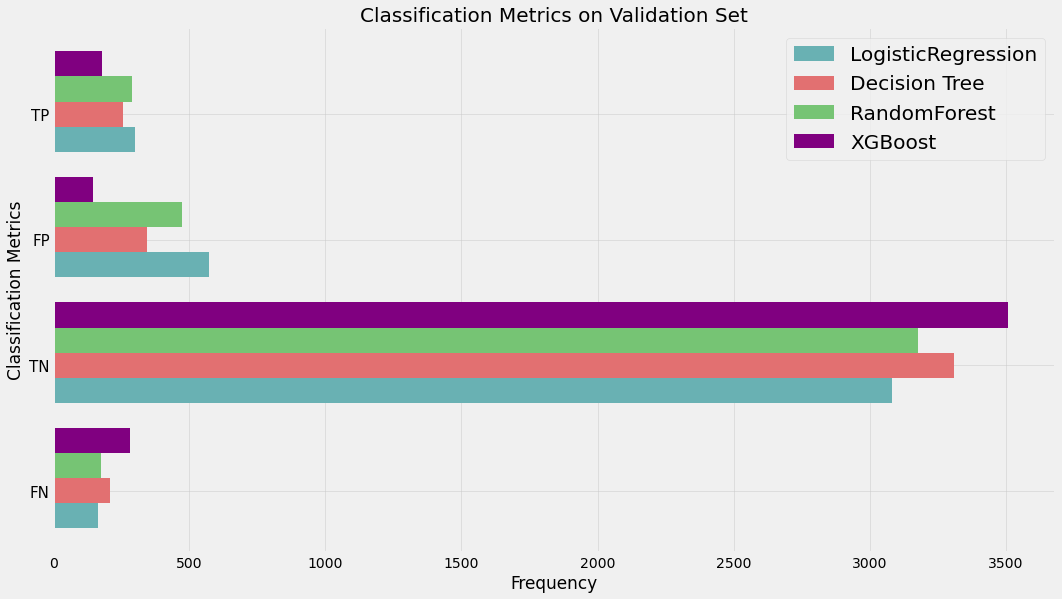

In [192]:
plot_evaluation(y_test, gs_lr.predict(X_test_sc), gs_dt.predict(X_test_sc),
                gs_rf.predict(X_test_sc), gs_xg.predict(X_test_sc))

**Interpretation:**

The bar chart above shows the raw number of TP (correctly predicting successful case), FP (incorrectly predicting successful case), TN (correctly predicting unsuccessful case) and FN (incorrectly predicting unsuccessful case) by models. I can group them into 2 groups because Logistic Regression, Decision Tree and Random Forest are quite similar pictures. They predict a higher number of TP and FP (Positive class) when compared to XGBoost. However, in this project, the bank wants to reduce the cost of telemarketing so I want to ensure that the model predicts low FN and FP.

### ROC AUC

In [203]:
def plot_rocauc(y_test, y_pred1, y_pred2, y_pred3, y_pred4):
    
    """This function takes inputs and plots the ROC curve.
    parameters:
    y_test: testing data
    y_pred1: predicted result from model 1
    y_pred2: predicted result from model 2
    y_pred3: predicted result from model 3
    y_pred4: predicted result from model 4
    """
    
    # ROCAUC LogisticRegression
    logreg_fpr, logreg_tpr, thresh = roc_curve(y_test, y_pred1[:,1])
    logreg_auc = auc(logreg_fpr,logreg_tpr)
    logreg_auc
    
    # ROCAUC DecisionTree
    dt_fpr, dt_tpr, thresh = roc_curve(y_test, y_pred2[:,1])
    dt_auc = auc(dt_fpr,dt_tpr)
    dt_auc
    
    # ROCAUC RandomForestClassifier
    rf_fpr, rf_tpr, thresh = roc_curve(y_test, y_pred3[:,1])
    rf_auc = auc(rf_fpr,rf_tpr)
    rf_auc
    
    # ROCAUC XGBoost
    xg_fpr, xg_tpr, thresh = roc_curve(y_test, y_pred4[:,1])
    xg_auc = auc(xg_fpr,xg_tpr)
    xg_auc
    
    plt.figure(figsize=(16,9))

    plt.plot(logreg_fpr,logreg_tpr,label='LogisticRegression',linewidth=5,alpha=0.7)
    plt.plot(rf_fpr,rf_tpr,label='RandomForest',linewidth=5,alpha=0.7)
    plt.plot(dt_fpr,dt_tpr,label='DecisionTree',linewidth=5,alpha=0.7)
    plt.plot(xg_fpr,xg_tpr,label='XGBoost',linewidth=5,alpha=0.7)


    plt.plot([0,1],[0,1],color='gray',linestyle = 'dashed')
    plt.xlabel('False Positive Rate',size=15)
    plt.ylabel('True Positive Rate',size=15)
    plt.legend(fontsize=15)
    plt.title('ROC Curve',size=25)
    plt.show();

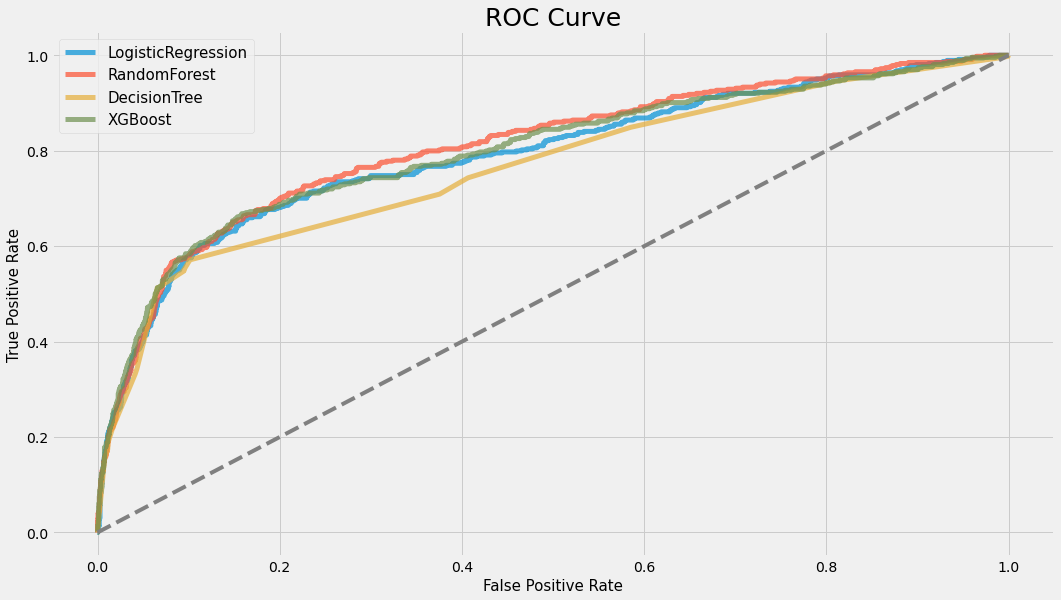

In [204]:
plot_rocauc(y_test, gs_lr.predict_proba(X_test_sc), gs_dt.predict_proba(X_test_sc),
            gs_rf.predict_proba(X_test_sc), gs_xg.predict_proba(X_test_sc))

|     Method           | Model |Training AUC score |CV AUC score|Validation AUC score|
|----------------|---------------|-----------|-----------|---------|
|All features|Logistic Regression|0.794|0.790|0.792|
|All features|Decision Tree|0.757|0.754|0.764|
|All features|Random Forest|0.795|0.790|0.808|
|All features|XGBoost|0.827|0.793|0.798|

**Interpretation:**
The ROC Curve above illustrates the performances of Logistic Regression, Decision Tree, Random Forest and XGBoost on the validation set. The model that scored the highest ROCAUC is Random Forest, followed by XGBoost, Logistic Regression and Decision Tree. However, the differences are very small differing by only around 0.01.

The ROCAUC score on the table above presents the ROCAUC score on training data, the cross-validation set and the validation set. For the CV AUC scores comparing, XGBoost gives the highest score and followed by Logistic Regression, Random Forest and Decision Tree. The difference is not large scale. At the ROCAUC score on training data, XGBoost appears the highest score but this model is slightly overfitting. For the other, the model seems not to overfit.

In this part, I select Random Forest as the best model because this model has a low FN and FP, high ROCAUC score and no overfit.

## Method 2 (Feature selection and more feature engineering)

Following the Method 1 and EDA part, I found that some features can be deleted because they have a low impact on the target. The features that I will drop are 'housing', 'age', 'previous', 'loan', 'campaign' and 'emp.var.rate' (I drop 'duration' in every method to build the future predictive model). Moreover, I do more feature engineering by removing the outliers, making the level of education and dummy.

### Feature Engineering

In [650]:
bank2 = bank
bank2.head()

age        job  marital    education  default  housing  loan    contact  \
0   56  housemaid  married     basic.4y       no        0     0  telephone   
1   57   services  married  high.school  unknown        0     0  telephone   
2   37   services  married  high.school       no        1     0  telephone   
3   40     admin.  married     basic.6y       no        0     0  telephone   
4   56   services  married  high.school       no        0     1  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1      0         0  nonexistent   
1   may         mon       149         1      0         0  nonexistent   
2   may         mon       226         1      0         0  nonexistent   
3   may         mon       151         1      0         0  nonexistent   
4   may         mon       307         1      0         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  target  
0           1.1          93.994          -36.4      4.857       5191.0       0  
1           1.1          93.994          -36.4      4.857       5191.0       0  
2           1.1          93.994          -36.4      4.857       5191.0       0  
3           1.1          93.994          -36.4      4.857       5191.0       0  
4           1.1          93.994          -36.4      4.857       5191.0       0

### Remove outline

The outliers in the campaign column are identified by IQR. If the number is lower or higher than IQR, it will be deleted.

In [652]:
numerical_features=['campaign']
for cols in numerical_features:
    Q1 = bank2[cols].quantile(0.25)
    Q3 = bank2[cols].quantile(0.75)
    IQR = Q3 - Q1     

    filter = (bank2[cols] >= Q1 - 1.5 * IQR) & (bank2[cols] <= Q3 + 1.5 *IQR)
    bank2=bank2.loc[filter]

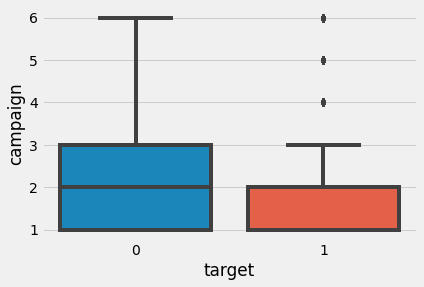

In [653]:
for col in numerical_features:
    sns.boxplot(x = 'target', y = col, data = bank2)
    plt.show()

### Education

I group the 'basic.9y', 'basic.6y' and 'basic.4y' to be one variable named 'middle.school', then I convert the string to integer with the level. 

In [209]:
lst=['basic.9y','basic.6y','basic.4y']
for i in lst:
    bank2.loc[bank2['education'] == i, 'education'] = "middle.school"

bank2['education'].value_counts()

middle.school          12560
university.degree      11634
high.school             9393
professional.course     5167
illiterate                17
Name: education, dtype: int64

In [210]:
bank2['education'] = bank2['education'].map(lambda x: 0 if x =='illiterate' else 1 if x =='middle.school' else 2 if x =='high.school' else 3 if x == 'university.degree' else 4)

### Dummy

In [211]:
bank_dummy02 = pd.get_dummies(bank2[['job', 'contact', 'marital', 'poutcome', 'default', 'day_of_week', 'month']], drop_first = True)

In [212]:
bank_02 = pd.concat([bank2.drop(columns = ['job', 'contact', 'marital', 'poutcome', 'default', 'day_of_week', 'month']), bank_dummy02], axis =1)

In [678]:
bank_02.head()

age  education  housing  loan  duration  campaign  pdays  previous  \
0   56          1        0     0       261         1      0         0   
1   57          2        0     0       149         1      0         0   
2   37          2        1     0       226         1      0         0   
3   40          1        0     0       151         1      0         0   
4   56          2        0     1       307         1      0         0   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  \
0           1.1          93.994          -36.4      4.857       5191.0   
1           1.1          93.994          -36.4      4.857       5191.0   
2           1.1          93.994          -36.4      4.857       5191.0   
3           1.1          93.994          -36.4      4.857       5191.0   
4           1.1          93.994          -36.4      4.857       5191.0   

   target  job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0       0                0                 0              1               0   
1       0                0                 0              0               0   
2       0                0                 0              0               0   
3       0                0                 0              0               0   
4       0                0                 0              0               0   

   job_retired  job_self-employed  job_services  job_student  job_technician  \
0            0                  0             0            0               0   
1            0                  0             1            0               0   
2            0                  0             1            0               0   
3            0                  0             0            0               0   
4            0                  0             1            0               0   

   job_unemployed  contact_telephone  marital_married  marital_single  \
0               0                  1                1               0   
1               0                  1                1               0   
2               0                  1                1               0   
3               0                  1                1               0   
4               0                  1                1               0   

   poutcome_nonexistent  poutcome_success  default_unknown  default_yes  \
0                     1                 0                0            0   
1                     1                 0                1            0   
2                     1                 0                0            0   
3                     1                 0                0            0   
4                     1                 0                0            0   

   day_of_week_mon  day_of_week_thu  day_of_week_tue  day_of_week_wed  \
0                1                0                0                0   
1                1                0                0                0   
2                1                0                0                0   
3                1                0                0                0   
4                1                0                0                0   

   month_aug  month_dec  month_jul  month_jun  month_mar  month_may  \
0          0          0          0          0          0          1   
1          0          0          0          0          0          1   
2          0          0          0          0          0          1   
3          0          0          0          0          0          1   
4          0          0          0          0          0          1   

   month_nov  month_oct  month_sep  
0          0          0          0  
1          0          0          0  
2          0          0          0  
3          0          0          0  
4          0          0          0

### Train-Test-Split

In [591]:
features_02 = bank_02.drop(columns = ['target','duration', 'housing', 'previous', 'loan', 'emp.var.rate']).columns
X_2 = bank_02[features_02]
y_2 = bank_02['target']

In [593]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2,y_2, stratify=y_2, test_size = 0.1, random_state = 42)

In [594]:
X_train2.shape

(34893, 38)

In [595]:
X_test2.shape

(3878, 38)

In [596]:
y_train2.shape

(34893,)

In [597]:
y_test2.shape

(3878,)

### Model

#### StandardScaler

In [599]:
ss = StandardScaler()
X_train2_sc = ss.fit_transform(X_train2)
X_test2_sc = ss.transform(X_test2)

### A. Logistic Regression

In [601]:
gs_lr2 = GridSearchCV(pipe_lr,
                      param_grid = pipe_lr_params,
                      cv=5,
                      n_jobs= -1,
                      scoring='roc_auc',
                      verbose=10)

In [602]:
gs_lr2.fit(X_train2_sc, y_train2)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.01, 0.1, 1], 'lr__penalty': ['l1', 'l2'],
                         'sm__k_neighbors': [3, 5]},
             scoring='roc_auc', verbose=10)

In [622]:
lr_coef2 = pd.DataFrame(sorted(list(zip(X_train2.columns,np.exp(gs_lr2.best_estimator_.steps[1][1].coef_[0]))),key=lambda row : row[1],reverse=True),columns=['Feature','Exp(coef)'])
lr_coef2.head(10)

Feature  Exp(coef)
0      poutcome_success   1.363350
1  poutcome_nonexistent   1.253225
2         cons.conf.idx   1.219690
3             month_mar   1.117698
4        cons.price.idx   1.102477
5             month_jun   1.072359
6                 pdays   1.068442
7           job_retired   1.062584
8        marital_single   1.055929
9           job_student   1.053703

**Interpretation:** 

From the coefficient value, the most important factors affecting the campaign subscription includes poutcome_success, poutcome_nonexistent, cons.conf.idx. In fact, an increase of one unit of the poutcome_success results in the increasing of chance that the customer will be the successful case 1.36 times. 

In [603]:
print('Best parameters: ', gs_lr2.best_params_)
print('Best estimator\'s CV AUC score: ', gs_lr2.best_score_) 
print('Training AUC score:', gs_lr2.score(X_train2_sc, y_train2))
print('Validation AUC score:', gs_lr2.score(X_test2_sc, y_test2))

Best parameters:  {'lr__C': 0.01, 'lr__penalty': 'l2', 'sm__k_neighbors': 3}
Best estimator's CV AUC score:  0.7883322214655877
Training AUC score: 0.7909927629737541
Validation AUC score: 0.8148524838465381


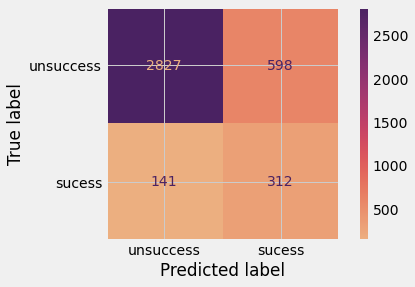

In [623]:
plot_confusion_matrix(gs_lr2,X_test2_sc,y_test2,cmap='flare',display_labels=['unsuccess','sucess']);

In [625]:
evaluation(y_test2, gs_lr2.predict(X_test2_sc))

Accuracy is 0.809
Misclassification rate is 0.191
Sensitivity is 0.689
Specificity is 0.825
Precision is 0.343


|     Method           | Model |Training AUC score |CV AUC score|Validation AUC score|
|----------------|---------------|-----------|-----------|---------|
|All features|Logistic Regression|0.794|0.790|0.792|
|All features|Decision Tree|0.757|0.754|0.764|
|All features|Random Forest|0.795|0.790|0.808|
|All features|XGBoost|0.827|0.793|0.798|
|More feature engineering|Logistic Regression|0.791|0.788|0.815|

- The Logistic Regression model built has a relatively good ROCAUC score on the validation set at 0.815 which is slightly higher than the training data and the cross-validation set. 
- The confusion matrix above shows that the model correctly classed that samples have 'unsuccess' 2827 cases. However, the model predicts incorrect result at 141 and 598 for False Negative and False Positive which is quite high. When compared to the Logistic Regression in method 1, method 2 decreases the False Negative but increase False Positive.
- The sensitivity is 0.689 which means this model can predict successful case 68.9% of all successful cases.

### C. Decision Tree

In [604]:
gs_dt2 = GridSearchCV(pipe_dt,
                      param_grid=pipe_dt_params,
                      cv=5, 
                      n_jobs=-1,
                      scoring='roc_auc',
                      verbose=10)

In [605]:
gs_dt2.fit(X_train2_sc, y_train2)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'dt__max_depth': [3, 5],
                         'dt__min_samples_split': [5, 7],
                         'sm__k_neighbors': [3, 5]},
             scoring='roc_auc', verbose=10)

### Evaluation

In [606]:
print('Best parameters: ', gs_dt2.best_params_)
print('Best CV AUC score: ', gs_dt2.best_score_)
print('Training AUC score:', gs_dt2.score(X_train2_sc, y_train2))
print('Validation AUC score:', gs_dt2.score(X_test2_sc, y_test2))

Best parameters:  {'dt__max_depth': 5, 'dt__min_samples_split': 5, 'sm__k_neighbors': 3}
Best CV AUC score:  0.7679720912289969
Training AUC score: 0.7763556912600276
Validation AUC score: 0.7951360757963938


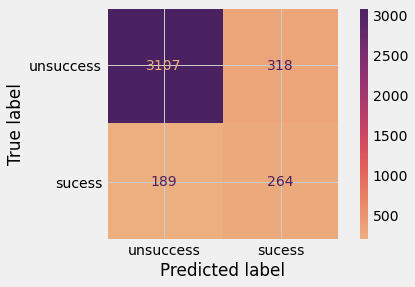

In [619]:
plot_confusion_matrix(gs_dt2,X_test2_sc,y_test2,cmap='flare',display_labels=['unsuccess','sucess']);

In [621]:
evaluation(y_test2, gs_dt2.predict(X_test2_sc))

Accuracy is 0.869
Misclassification rate is 0.131
Sensitivity is 0.583
Specificity is 0.907
Precision is 0.454


|     Method           | Model |Training AUC score |CV AUC score|Validation AUC score|
|----------------|---------------|-----------|-----------|---------|
|All features|Logistic Regression|0.794|0.790|0.792|
|All features|Decision Tree|0.757|0.754|0.764|
|All features|Random Forest|0.795|0.790|0.808|
|All features|XGBoost|0.827|0.793|0.798|
|More feature engineering|Logistic Regression|0.791|0.788|0.815|
|More feature engineering|Decision Tree|0.776|0.767|0.795|

- The Decision Tree model built has a relatively good ROCAUC score on validation at 0.795 which is slightly higher that the training data and the cross validation set. 
- The confusion matrix above shows that the model corectly classed that samples have 'unsuccess' 3107 cases. However, the model predict incorrect result at 189 and 318 for False Negative and False Positive which is quite high but it is lower than the one from Logistic Regression (method 2). When compared to the Decision Tree in method 1, the method 2 reduces both False Negative and False Positive.
- The sensitivity is 0.583 which means this model can predict successful case 58.3% of all successful cases.

### D. Random Forest

In [607]:
gs_rf2 = GridSearchCV(pipe_rf,
                     param_grid=pipe_rf_params,
                     cv=5, 
                     n_jobs=-1,
                     scoring='roc_auc',
                     verbose=10)

In [608]:
gs_rf2.fit(X_train2_sc, y_train2)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [3, 5],
                         'rf__min_samples_split': [2, 4],
                         'rf__n_estimators': [50, 100],
                         'sm__k_neighbors': [3, 5]},
             scoring='roc_auc', verbose=10)

### Evaluation

In [609]:
print('Best parameters: ', gs_rf2.best_params_)
print('Best CV AUC score: ', gs_rf2.best_score_)
print('Training AUC score:', gs_rf2.score(X_train2_sc, y_train2))
print('Validation AUC score:', gs_rf2.score(X_test2_sc, y_test2))

Best parameters:  {'rf__max_depth': 5, 'rf__min_samples_split': 4, 'rf__n_estimators': 100, 'sm__k_neighbors': 3}
Best CV AUC score:  0.7926106932803643
Training AUC score: 0.797089713723993
Validation AUC score: 0.8108354683295467


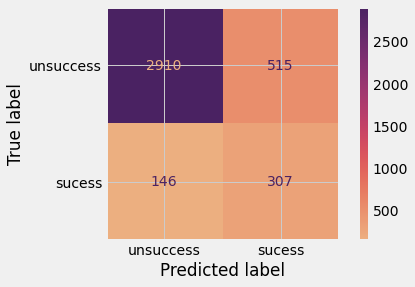

In [616]:
plot_confusion_matrix(gs_rf2,X_test2_sc,y_test2,cmap='flare',display_labels=['unsuccess','sucess']);

In [618]:
evaluation(y_test2, gs_rf2.predict(X_test2_sc))

Accuracy is 0.83
Misclassification rate is 0.17
Sensitivity is 0.678
Specificity is 0.85
Precision is 0.373


|     Method           | Model |Training AUC score |CV AUC score|Validation AUC score|
|----------------|---------------|-----------|-----------|---------|
|All features|Logistic Regression|0.794|0.790|0.792|
|All features|Decision Tree|0.757|0.754|0.764|
|All features|Random Forest|0.795|0.790|0.808|
|All features|XGBoost|0.827|0.793|0.798|
|More feature engineering|Logistic Regression|0.791|0.788|0.815|
|More feature engineering|Decision Tree|0.785|0.775|0.804|
|More feature engineering|Random Forest|0.797|0.792|0.810|

- The Random Forest model built has a relatively good ROCAUC score on validation at 0.810 which is slightly higher than the training data and the cross-validation set. 
- The confusion matrix above shows that the model correctly classed that samples have 'unsuccess' 2910 cases. However, the model predicts incorrect result at 146 and 515 for False Negative and False Positive which is quite high and the results are higher than the Random Forest in method 1.
- The sensitivity is 0.678 which means this model can predict successful case 67.8% of all successful cases.

### XGBoost

In [664]:
gs_xg2 = GridSearchCV(pipe_xg,
                     param_grid=pipe_xg_params,
                     cv=5, 
                     n_jobs=-1,
                     scoring='roc_auc',
                     verbose=10)

In [691]:
gs_xg2.fit(X_train2_sc, y_train2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[09:08:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('xg',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                 

### Evaluation

In [692]:
print('Best parameters: ', gs_xg2.best_params_)
print('Best CV AUC score: ', gs_xg2.best_score_)
print('Training AUC score:', gs_xg2.score(X_train2_sc, y_train2))
print('Validation AUC score:', gs_xg2.score(X_test2_sc, y_test2))

Best parameters:  {'sm__k_neighbors': 5, 'xg__learning_rate': 0.1, 'xg__max_depth': 5, 'xg__min_child_weight': 4}
Best CV AUC score:  0.7905833187136178
Training AUC score: 0.8215442851301547
Validation AUC score: 0.8145485892911812


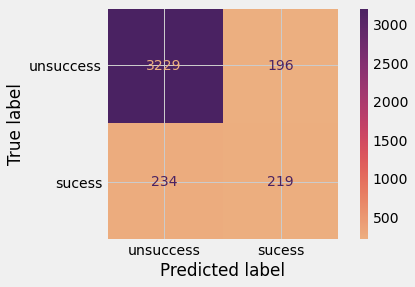

In [667]:
plot_confusion_matrix(gs_xg2,X_test2_sc,y_test2,cmap='flare',display_labels=['unsuccess','sucess']);

In [669]:
evaluation(y_test2, gs_xg2.predict(X_test2_sc))

Accuracy is 0.889
Misclassification rate is 0.111
Sensitivity is 0.483
Specificity is 0.943
Precision is 0.528


|     Method           | Model |Training AUC score |CV AUC score|Validation AUC score|
|----------------|---------------|-----------|-----------|---------|
|All features|Logistic Regression|0.794|0.790|0.792|
|All features|Decision Tree|0.757|0.754|0.764|
|All features|Random Forest|0.795|0.790|0.808|
|All features|XGBoost|0.827|0.793|0.798|
|More feature engineering|Logistic Regression|0.791|0.788|0.815|
|More feature engineering|Decision Tree|0.785|0.775|0.804|
|More feature engineering|Random Forest|0.796|0.792|0.810|
|More feature engineering|XGBoost|0.799|0.790|0.815|

- The XGBoost model built has a relatively good ROCAUC score on validation at 0.815 which is slightly higher than the training data and the cross-validation set. 
- The confusion matrix above shows that the model correctly classed that samples have 'unsuccess' 3229 cases. However, the model predicts incorrect result at 196 and 234 for False Negative and False Positive.
- The sensitivity is 0.483 which means this model can predict successful case 48.3% of all successful cases.

## Model Evaluation/Comparison

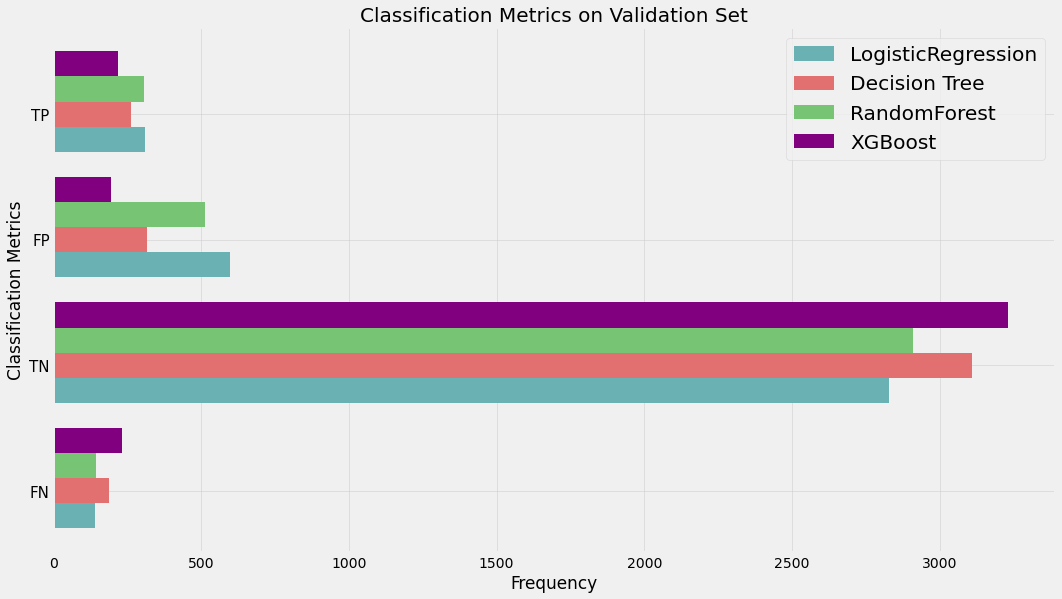

In [670]:
plot_evaluation(y_test2, gs_lr2.predict(X_test2_sc), gs_dt2.predict(X_test2_sc),
                gs_rf2.predict(X_test2_sc), gs_xg2.predict(X_test2_sc))

**Interpretation:**

All models give a similar number of TP (True positive), but Logistic Regression and Random Forest present a high number in the FP (False positive). XGBoost and Decision Tree predict a higher number of TN (True negative) and FN (False negative) when compared to Logistic Regression and Random Forest.

### ROC AUC

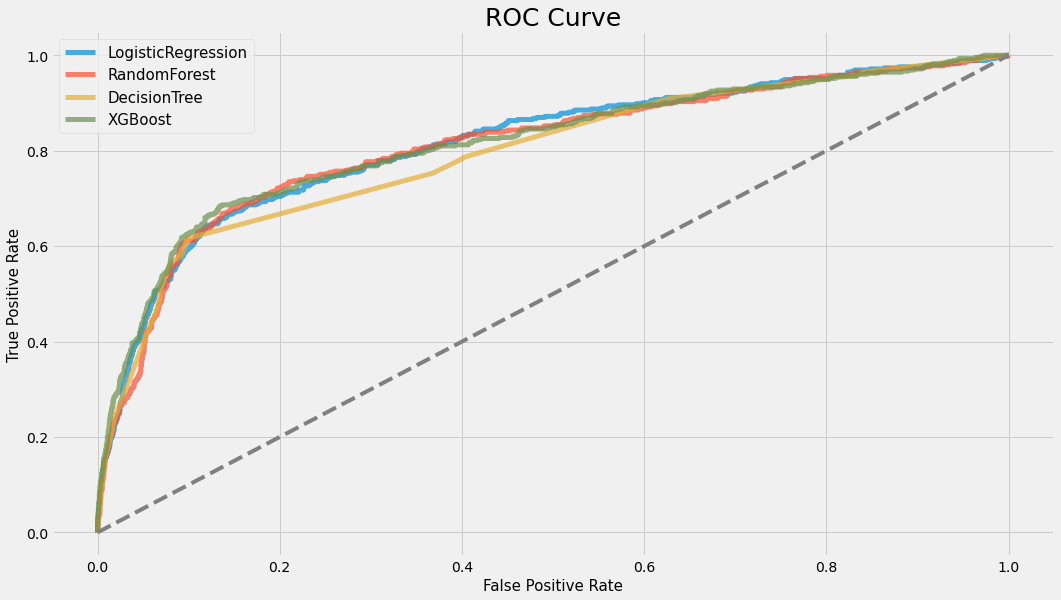

In [694]:
plot_rocauc(y_test2, gs_lr2.predict_proba(X_test2_sc), gs_dt2.predict_proba(X_test2_sc),
            gs_rf2.predict_proba(X_test2_sc), gs_xg2.predict_proba(X_test2_sc))

|     Method           | Model |Training AUC score |CV AUC score|Validation AUC score|
|----------------|---------------|-----------|-----------|---------|
|More feature engineering|Logistic Regression|0.791|0.788|0.815|
|More feature engineering|Decision Tree|0.785|0.775|0.804|
|More feature engineering|Random Forest|0.796|0.792|0.810|
|More feature engineering|XGBoost|0.799|0.789|0.815|

**Interpretation:**
The ROC Curve above illustrates the performances of Logistic Regression, Decision Tree, Random Forest and XGBoost on the validation set. The model that scored the highest ROCAUC on CV is Random Forest, followed by XGBoost, Logistic Regression and Decision Tree. However, the differences are very small differing.

The ROCAUC score on the table above presents the ROCAUC score on training data, the cross-validation set and the validation set. For the CV AUC scores comparing, Random Forest gives the highest score and followed by XGBoost, Logistic Regression and Decision Tree. The difference is not large scale and no model overfits.

In this part, I select XGBoost as the best model because this model has low FP and FN. For the ROCAUC score, XGBoost does not have a high difference when compared with other models.

## Method 3 (PCA)

This part is adapted from method 2 by using PCA to get more efficiency of the model.

In [107]:
pca = PCA()
Z_train = pca.fit_transform(X_train2_sc)
Z_test = pca.transform(X_test2_sc)

### A. Logistic Regression

In [108]:
gs_lr3 = GridSearchCV(pipe_lr,
                      param_grid = pipe_lr_params,
                      cv=5,
                      n_jobs= -1,
                      scoring='roc_auc',
                      verbose=10)

In [109]:
gs_lr3.fit(Z_train, y_train2)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.01, 0.1, 1], 'lr__penalty': ['l1', 'l2'],
                         'sm__k_neighbors': [3, 5]},
             scoring='roc_auc', verbose=10)

In [737]:
lr_coef3 = pd.DataFrame(sorted(list(zip(X_train2.columns,np.exp(gs_lr3.best_estimator_.steps[1][1].coef_[0]))),key=lambda row : row[1],reverse=True),columns=['Feature','Exp(coef)'])
lr_coef3.head(10)

Feature  Exp(coef)
0               age   1.574826
1   day_of_week_mon   1.372572
2         month_may   1.250597
3    job_management   1.210090
4    cons.price.idx   1.185506
5             pdays   1.136953
6  poutcome_success   1.102955
7         month_dec   1.084579
8         month_nov   1.081128
9   marital_married   1.080912

**Interpretation:** 

From the coefficient value, the most important factors affecting the campaign subscription includes age, day_of_week_mon, month_may. In fact, an increase of one unit of the age results in the increasing of chance that the customer will be the successful case 1.57 times. 

### Evaluation

In [110]:
print('Best parameters: ', gs_lr3.best_params_)
print('Best estimator\'s CV AUC score: ', gs_lr3.best_score_) 
print('Training AUC score:', gs_lr3.score(Z_train, y_train2))
print('Validation AUC score:', gs_lr3.score(Z_test, y_test2))

Best parameters:  {'lr__C': 0.01, 'lr__penalty': 'l2', 'sm__k_neighbors': 3}
Best estimator's CV AUC score:  0.7888922794361258
Training AUC score: 0.79147733756107
Validation AUC score: 0.8155405165885177


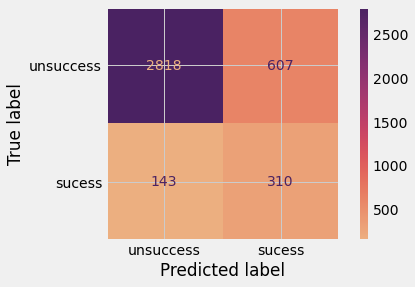

In [111]:
plot_confusion_matrix(gs_lr3,Z_test,y_test2,cmap='flare',display_labels=['unsuccess','sucess']);

In [236]:
evaluation(y_test2, gs_lr3.predict(Z_test))

Accuracy is 0.829
Misclassification rate is 0.171
Sensitivity is 0.366
Specificity is 0.891
Precision is 0.307


|     Method           | Model |Training AUC score |CV AUC score|Validation AUC score|
|----------------|---------------|-----------|-----------|---------|
|All features|Logistic Regression|0.794|0.790|0.792|
|All features|Decision Tree|0.757|0.754|0.764|
|All features|Random Forest|0.795|0.790|0.808|
|All features|XGBoost|0.827|0.793|0.798|
|More feature engineering|Logistic Regression|0.791|0.788|0.815|
|More feature engineering|Decision Tree|0.785|0.775|0.804|
|More feature engineering|Random Forest|0.796|0.792|0.810|
|More feature engineering|XGBoost|0.799|0.789|0.815|
|PCA|Logistic Regression|0.791|0.788|0.815|

- The Logistic Regression model built has a relatively good ROCAUC score on validation at 0.815 which is slightly higher than the training data and the cross-validation set. 
- The confusion matrix above shows that the model correctly classed that samples have 'unsuccess' 2818 cases. However, the model predicts incorrect result at 143 and 607 for False Negative and False Positive which is quite high. 
- The sensitivity is 0.366 which means this model can predict successful case 36.6% of all successful cases.

### C. Decision Tree

In [114]:
gs_dt3 = GridSearchCV(pipe_dt,
                      param_grid=pipe_dt_params,
                      cv=5, 
                      n_jobs=-1,
                      scoring='roc_auc',
                      verbose=10)

In [115]:
gs_dt3.fit(Z_train, y_train2)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'dt__max_depth': [3, 5],
                         'dt__min_samples_split': [5, 7],
                         'sm__k_neighbors': [3, 5]},
             scoring='roc_auc', verbose=10)

### Evaluation

In [116]:
print('Best parameters: ', gs_dt3.best_params_)
print('Best CV AUC score: ', gs_dt3.best_score_)
print('Training AUC score:', gs_dt3.score(Z_train, y_train2))
print('Validation AUC score:', gs_dt3.score(Z_test, y_test2))

Best parameters:  {'dt__max_depth': 5, 'dt__min_samples_split': 5, 'sm__k_neighbors': 3}
Best CV AUC score:  0.7750498235340795
Training AUC score: 0.7860739182383654
Validation AUC score: 0.7814140925863263


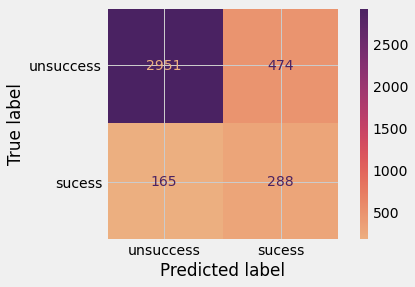

In [119]:
plot_confusion_matrix(gs_dt3,Z_test,y_test2,cmap='flare',display_labels=['unsuccess','sucess']);

In [237]:
evaluation(y_test2, gs_dt3.predict(Z_test))

Accuracy is 0.671
Misclassification rate is 0.329
Sensitivity is 0.519
Specificity is 0.691
Precision is 0.182


|     Method           | Model |Training AUC score |CV AUC score|Validation AUC score|
|----------------|---------------|-----------|-----------|---------|
|All features|Logistic Regression|0.794|0.790|0.792|
|All features|Decision Tree|0.757|0.754|0.764|
|All features|Random Forest|0.795|0.790|0.808|
|All features|XGBoost|0.827|0.793|0.798|
|More feature engineering|Logistic Regression|0.791|0.788|0.815|
|More feature engineering|Decision Tree|0.785|0.775|0.804|
|More feature engineering|Random Forest|0.796|0.792|0.810|
|More feature engineering|XGBoost|0.799|0.789|0.815|
|PCA|Logistic Regression|0.791|0.788|0.815|
|PCA|Decision Tree|0.786|0.775|0.781|

- The Decision Tree model built has a relatively good ROCAUC score on training data at 0.786 which is slightly higher than the validation and the cross-validation set. 
- The confusion matrix above shows that the model correctly classed that samples have 'unsuccess' 2951 cases. However, the model predicts incorrect result at 165 and 474 for False Negative and False Positive which are quite high but the False Positive is lower than the result from the Logistic Regression (method3).
- The sensitivity is 0.519 which means this model can predict successful case 51.9% of all successful cases.

### D. Random Forest

In [121]:
gs_rf3 = GridSearchCV(pipe_rf,
                     param_grid=pipe_rf_params,
                     cv=5, 
                     n_jobs=-1,
                     scoring='roc_auc',
                     verbose=10)

In [122]:
gs_rf3.fit(Z_train, y_train2)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [3, 5],
                         'rf__min_samples_split': [2, 4],
                         'rf__n_estimators': [50, 100],
                         'sm__k_neighbors': [3, 5]},
             scoring='roc_auc', verbose=10)

### Evaluation

In [123]:
print('Best parameters: ', gs_rf3.best_params_)
print('Best CV AUC score: ', gs_rf3.best_score_)
print('Training AUC score:', gs_rf3.score(Z_train, y_train2))
print('Validation AUC score:', gs_rf3.score(Z_test, y_test2))

Best parameters:  {'rf__max_depth': 5, 'rf__min_samples_split': 4, 'rf__n_estimators': 100, 'sm__k_neighbors': 3}
Best CV AUC score:  0.7938757900745266
Training AUC score: 0.8030492218912778
Validation AUC score: 0.8083372810621807


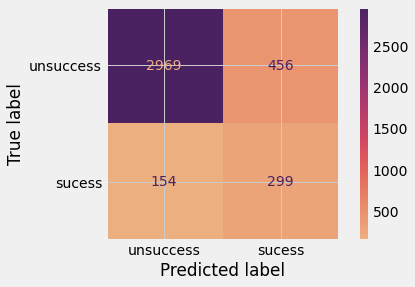

In [124]:
plot_confusion_matrix(gs_rf3,Z_test,y_test2,cmap='flare',display_labels=['unsuccess','sucess']);

In [238]:
evaluation(y_test2, gs_rf3.predict(Z_test))

Accuracy is 0.774
Misclassification rate is 0.226
Sensitivity is 0.481
Specificity is 0.813
Precision is 0.254


|     Method           | Model |Training AUC score |CV AUC score|Validation AUC score|
|----------------|---------------|-----------|-----------|---------|
|All features|Logistic Regression|0.794|0.790|0.792|
|All features|Decision Tree|0.757|0.754|0.764|
|All features|Random Forest|0.795|0.790|0.808|
|All features|XGBoost|0.827|0.793|0.798|
|More feature engineering|Logistic Regression|0.791|0.788|0.815|
|More feature engineering|Decision Tree|0.785|0.775|0.804|
|More feature engineering|Random Forest|0.796|0.792|0.810|
|More feature engineering|XGBoost|0.799|0.789|0.815|
|PCA|Logistic Regression|0.791|0.788|0.815|
|PCA|Decision Tree|0.786|0.775|0.781|
|PCA|Random Forest|0.803|0.793|0.808|

- The Random Forest model built has a relatively good ROCAUC score on the validation at 0.808 which is slightly higher than the training data and the cross-validation set. 
- The confusion matrix above shows that the model correctly classed that samples have 'unsuccess' 2969 cases. However, the model predicts incorrect result at 154 and 456 for False Negative and False Positive. 
- The sensitivity is 0.481 which means this model can predict successful case 48.1% of all successful cases.

### XGBoost

In [127]:
gs_xg3 = GridSearchCV(pipe_xg,
                     param_grid=pipe_xg_params,
                     cv=5, 
                     n_jobs=-1,
                     scoring='roc_auc',
                     verbose=10)

In [128]:
gs_xg3.fit(Z_train, y_train2)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[11:14:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm', SMOTE(random_state=42)),
                                       ('xg',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                 

### Evaluation

In [132]:
print('Best parameters: ', gs_xg3.best_params_)
print('Best CV AUC score: ', gs_xg3.best_score_)
print('Training AUC score:', gs_xg3.score(Z_train, y_train2))
print('Validation AUC score:', gs_xg3.score(Z_test, y_test2))

Best parameters:  {'sm__k_neighbors': 3, 'xg__learning_rate': 0.01, 'xg__max_depth': 5, 'xg__min_child_weight': 2}
Best CV AUC score:  0.7897573197373337
Training AUC score: 0.8070479128005424
Validation AUC score: 0.805272554422262


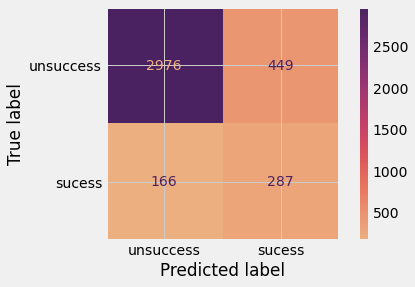

In [133]:
plot_confusion_matrix(gs_xg3,Z_test,y_test2,cmap='flare',display_labels=['unsuccess','sucess']);

In [239]:
evaluation(y_test2, gs_xg3.predict(Z_test))

Accuracy is 0.665
Misclassification rate is 0.335
Sensitivity is 0.62
Specificity is 0.671
Precision is 0.199


|     Method           | Model |Training AUC score |CV AUC score|Validation AUC score|
|----------------|---------------|-----------|-----------|---------|
|All features|Logistic Regression|0.794|0.790|0.792|
|All features|Decision Tree|0.757|0.754|0.764|
|All features|Random Forest|0.795|0.790|0.808|
|All features|XGBoost|0.827|0.793|0.798|
|More feature engineering|Logistic Regression|0.791|0.788|0.815|
|More feature engineering|Decision Tree|0.785|0.775|0.804|
|More feature engineering|Random Forest|0.796|0.792|0.810|
|More feature engineering|XGBoost|0.799|0.789|0.815|
|PCA|Logistic Regression|0.791|0.788|0.815|
|PCA|Decision Tree|0.786|0.775|0.781|
|PCA|Random Forest|0.803|0.793|0.808|
|PCA|XGBoost|0.807|0.789|0.805|

- The XGBoost model built has a relatively good ROCAUC score on validation data at 0.805 which is slightly higher than the testing data and the cross-validation set. 
- The confusion matrix above shows that the model correctly classed that samples have 'unsuccess' 2976 cases. However, the model predicts incorrect result at 166 and 449 for False Negative and False Positive which is quite high, but they are not differ significantly from other models in method 3.
- The sensitivity is 0.62 which means this model can predict successful case 62% of all successful cases.

## Model Evaluation/Comparison

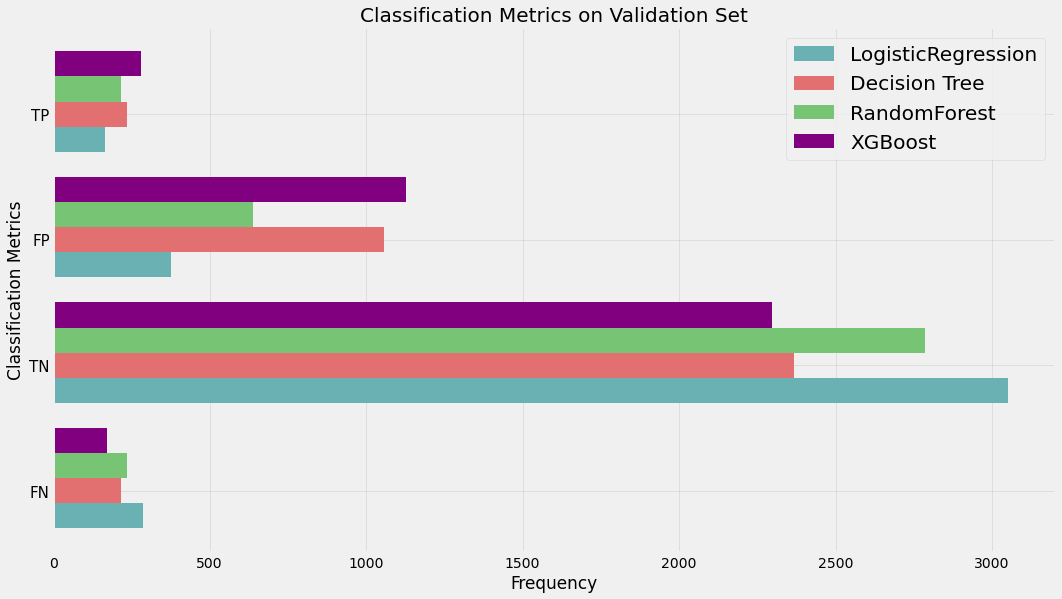

In [225]:
plot_evaluation(y_test2, gs_lr3.predict(Z_test), gs_dt3.predict(Z_test),
                gs_rf3.predict(Z_test), gs_xg3.predict(Z_test))

**Interpretation:**

All models present the low of TP (True positive) and FN (False Negative), but the FP and TN results can be grouped into 2 groups. The first group is Random Forest and Logistic Regression, these models have the low FP (Flase positive) and high TN (True negative). The second group consists of XGBoost and Logistic Regression, these model have the high FP (False positive) and low TN (True negative). 

### ROC AUC

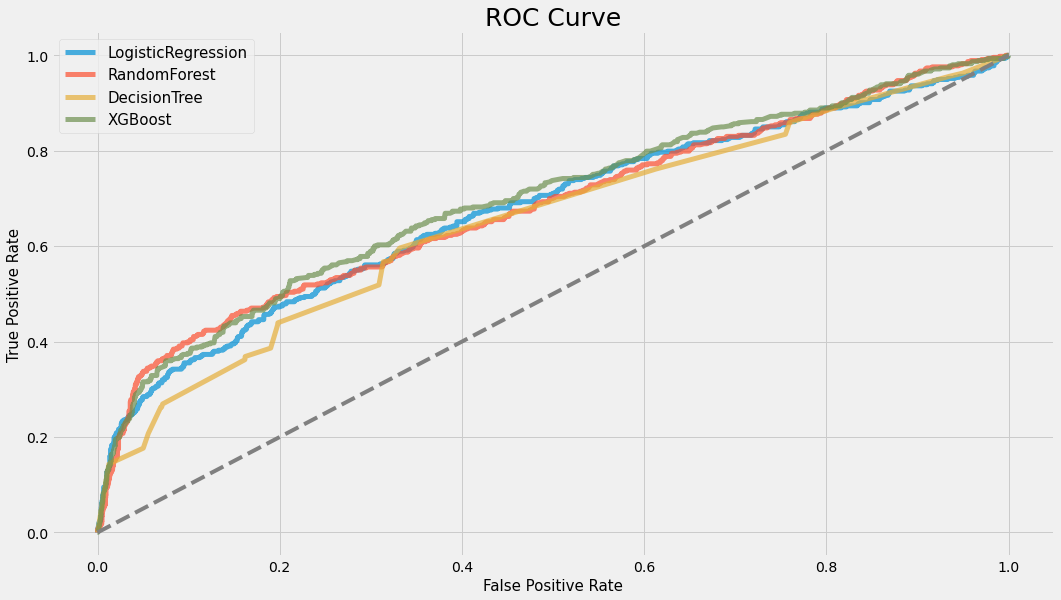

In [228]:
plot_rocauc(y_test2, gs_lr3.predict_proba(Z_test), gs_dt3.predict_proba(Z_test),
            gs_rf3.predict_proba(Z_test), gs_xg3.predict_proba(Z_test))

|     Method           | Model |Training AUC score |CV AUC score|Validation AUC score|
|----------------|---------------|-----------|-----------|---------|
|PCA|Logistic Regression|0.791|0.788|0.815|
|PCA|Decision Tree|0.786|0.775|0.781|
|PCA|Random Forest|0.803|0.793|0.808|
|PCA|XGBoost|0.789|0.807|0.805|

**Interpretation:**

The ROC Curve above illustrates the performances of Logistic Regression, Decision Tree, Random Forest and XGBoost on the validation set. The model that scored the highest ROCAUC is Random Forest, followed by XGBoost, Logistic Regression and Decision Tree. However, the differences are very small differing by only around 0.01.

The ROCAUC score on the table above presents the ROCAUC score on training data, the cross-validation set and the validation set. For the CV AUC scores comparing, XGBoost gives the highest score and followed by Random Forest, Logistic Regression and Decision Tree. The differences are not large scale. At the ROCAUC score on training data, Random Forest appears the highest score.

In this part, I select Logistic Regression as the best model because the prediction result from this model has low FP and FN and ROCAUC is not low.

## Model Selection

In [695]:
model1 = (confusion_matrix(y_test, gs_rf.predict(X_test_sc))).ravel()
model2 = (confusion_matrix(y_test2, gs_xg2.predict(X_test2_sc))).ravel()
model3 = (confusion_matrix(y_test2, gs_lr3.predict(Z_test))).ravel()
#tn, fp, fn, tp
model1 = [model1[3],model1[1],model1[0],model1[2]]
model2 = [model2[3],model2[1],model2[0],model2[2]]
model3 = [model3[3],model3[1],model3[0],model3[2]]

In [696]:
model1

[288, 475, 3179, 176]

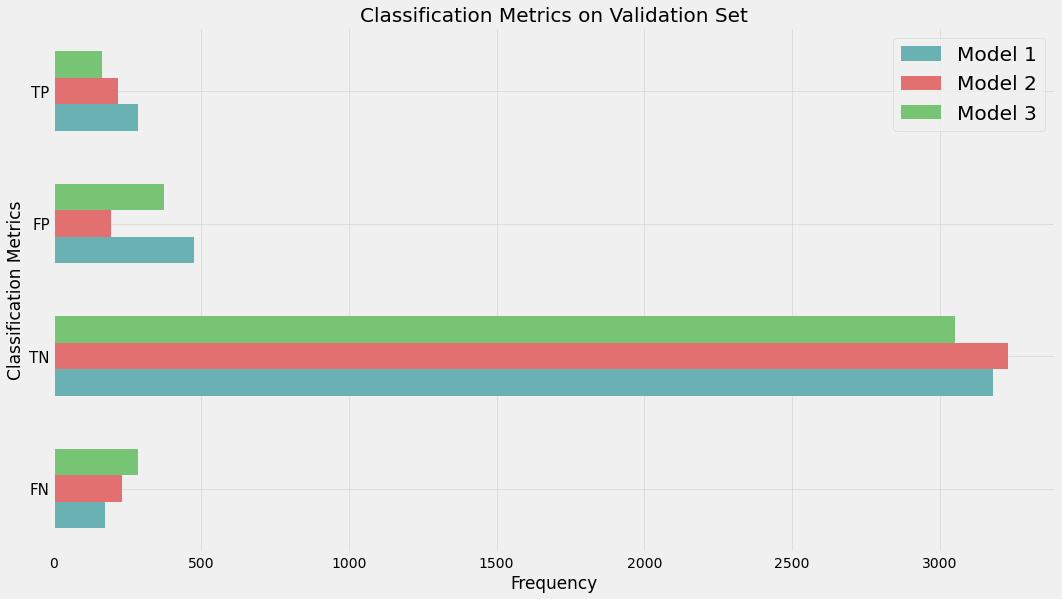

In [697]:

ind = np.arange(4)  # the x locations for the groups
width = 0.20       # the width of the bars

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
rects1 = ax.barh(ind, model1[::-1], width, color='#69b1b3')
rects2 = ax.barh(ind+width, model2[::-1], width, color='#e27071')
rects3 = ax.barh(ind+2*width,model3[::-1], width, color='#76c474')


#['#69b1b3','#76c474','#ebdf6a','#e27071','#de4648','#8D6A9F','#8CBCB9']
# add some
ax.set_ylabel('Classification Metrics', size = 17)
ax.set_xlabel('Frequency', size = 17)
ax.set_title('Classification Metrics on Validation Set', size = 20)
ax.set_yticks(ind + width )
ax.set_yticklabels(['TP', 'FP', 'TN', 'FN'][::-1],size=15)
ax.legend( (rects1[0], rects2[0],rects3[0]), ('Model 1', 'Model 2','Model 3'),fontsize = 'x-large')
plt.grid(axis='both',which='both',alpha=0.5)
plt.show()

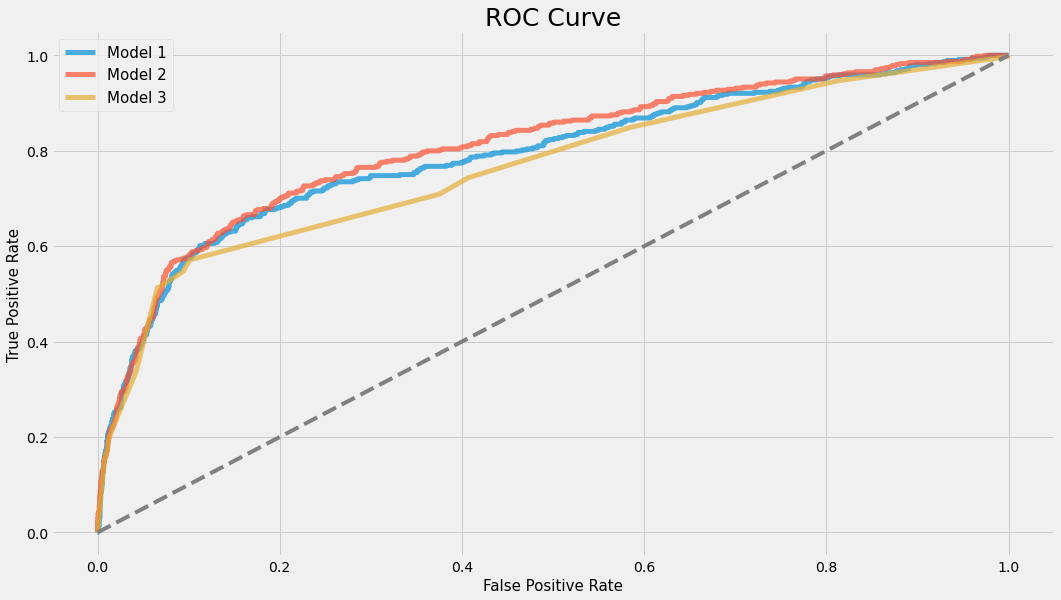

In [698]:
# ROCAUC Model1
model1_fpr, model1_tpr, thresh = roc_curve(y_test, gs_lr.predict_proba(X_test_sc)[:,1])
model1_auc = auc(model1_fpr,model1_tpr)
model1_auc

# ROCAUC Model2
model2_fpr, model2_tpr, thresh = roc_curve(y_test2, gs_lr2.predict_proba(X_test2_sc)[:,1])
model2_auc = auc(model2_fpr,model2_tpr)
model2_auc

# ROCAUC Model3
model3_fpr, model3_tpr, thresh = roc_curve(y_test2, gs_xg3.predict_proba(Z_test)[:,1])
model3_auc = auc(model3_fpr,model3_tpr)
model3_auc

plt.figure(figsize=(16,9))

plt.plot(logreg_fpr,logreg_tpr,label='Model 1',linewidth=5,alpha=0.7)
plt.plot(rf_fpr,rf_tpr,label='Model 2',linewidth=5,alpha=0.7)
plt.plot(dt_fpr,dt_tpr,label='Model 3',linewidth=5,alpha=0.7)


plt.plot([0,1],[0,1],color='gray',linestyle = 'dashed')
plt.xlabel('False Positive Rate',size=15)
plt.ylabel('True Positive Rate',size=15)
plt.legend(fontsize=15)
plt.title('ROC Curve',size=25)
plt.show();

**Interpretation:**
From the ROCAUR curve above, the model2 (XGBoost from model2) gives the best ROCAUC score while Logistic Regression from method 3 presents the lowest ROCAUC score. The bar graph illustrates the XGBoost has the lowest FP and is the second of FN. Therefore, I select the XGBoost from method 2 to be the best performing model for this project.

### Feature Importance

I do this part because I would like the importance score for each feature that indicated how useful or valuable each feature was in the construction of the trees within the model. The parameter in the model I bring from the best parameter result of XGBoost in Method 2.

In [699]:
sm = SMOTE(random_state = 42, k_neighbors = 5) # imbalanced data

In [700]:
Xsm_train, ysm_train = sm.fit_resample(X_train2_sc, y_train2)

In [701]:
xg = XGBClassifier(learning_rate = 0.1, max_depth = 5, min_child_weight= 4) # best params

In [702]:
xg.fit(Xsm_train, ysm_train)

[10:18:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [712]:
# Create the feature importance dataframe
importances = pd.DataFrame({
    'Feature': X_2.columns,
    'Importance': xg.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.reset_index(drop=True)
importances.head(10)

Feature  Importance
0           nr.employed    0.200778
1              campaign    0.087611
2       default_unknown    0.081060
3     contact_telephone    0.074586
4             education    0.071221
5             month_oct    0.061752
6       marital_married    0.046706
7  poutcome_nonexistent    0.040741
8         cons.conf.idx    0.036937
9      poutcome_success    0.033938

Text(0.5, 1.0, 'Importance score for each feature')

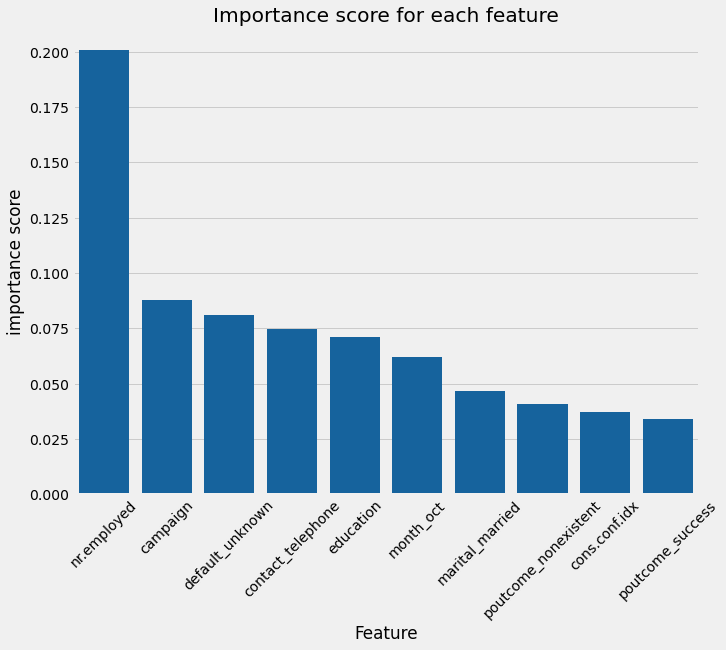

In [734]:
# Plot the feature importance
plt.figure(figsize=(10,8))
sns.barplot(x="Feature", y="Importance", data=importances.head(10), palette=['#0066b3'])
plt.xticks(rotation=45)
plt.ylabel('importance score')
plt.title('Importance score for each feature')

I choose to plot 10 feature with a high importance score. The nr.employed column has the most score it means this feature is the most important feature to split the tree in XGBoost model, followed by default_unknown and education.

## Cost Benefit Analysis

### Checking number of contact and duration

#### Without model

In [314]:
pct_no_yes = bank['target'].value_counts(normalize = True)

print('unsuccess rate was ', round(pct_no_yes[0]*100,0), '%')
print('success rate was ', round(pct_no_yes[1]*100,0), '%')

unsuccess rate was  89.0 %
success rate was  11.0 %


Observations:
Based on the dataset which has 41,177 samples, the bank telemarketing has a success rate to convince customer only at **11%**.

In [338]:
# print the average number of calls per customer, and avg call per successful/unsuccessful customers

avg_call = round(bank['campaign'].mean(), 0)
avg_yes_call = round(bank[bank['target'] == 1]['campaign'].mean(), 0)
avg_no_call = round(bank[bank['target'] == 0]['campaign'].mean(), 0)

print(f'The average calls was: {avg_call}')
print(f'The average calls for a succesful customer were: {avg_yes_call}')
print(f'The average calls for an unsuccesful customer were: {avg_no_call}')

The average calls was: 3.0
The average calls for a succesful customer were: 2.0
The average calls for an unsuccesful customer were: 3.0


**Interpretation:** 
- The average call per customer was 3 calls.
- The average call per customer who was interested in the campaign was 2 calls.
- The average call per customer who was not interested in the campaign was 3 calls.

You can see that the extra one call was made for the unsuccessful customer. This is the cost loss for the bank. So, let me show the relationship between the number of calls and the success rate to prove that more calls do not mean more success rate.

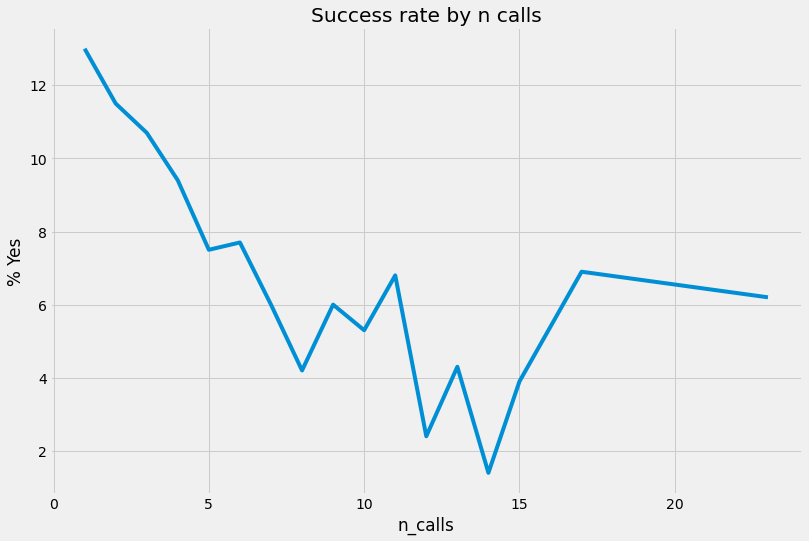

In [339]:
n_call_yes = bank[bank['target'] ==1]['campaign'].unique()
success_rate = []
for n in n_call_yes:
    rate = round(bank[bank['campaign'] == n]['target'].mean()*100,1)
    success_rate.append(rate)

# plot graph
plt.figure(figsize = (12,8))
sns.lineplot(x = n_call_yes, y = success_rate)
plt.title('Success rate by n calls')
plt.ylabel('% Yes')
plt.xlabel('n_calls');

Observations:
- The highest success rate was 13% for only one call to a customer.
- The number of calls had no positive impact on the success rate, therefore the bank should not call customer more than once.

Next step, I would like to that calculate the average duration.

In [345]:
# print the average number of calls per customer, and avg call per successful/unsuccessful customers

avg_time = round(bank['duration'].mean()/60, 1)
avg_yes_time = round(bank[bank['target'] == 1]['duration'].mean()/60, 1)
avg_no_time = round(bank[bank['target'] == 0]['duration'].mean()/60, 1)

print(f'The average duration was: {avg_time} minutes')
print(f'The average duration for a succesful customer were: {avg_yes_time} minutes')
print(f'The average duration for an unsuccesful customer were: {avg_no_time} minutes')

The average duration was: 4.3 minutes
The average duration for a succesful customer were: 9.2 minutes
The average duration for an unsuccesful customer were: 3.7 minutes


**Interpretation:** 
- The average duration per customer was 4.3 minutes
- The average duration per customer who was interested in the campaign was 9.2 minutes.
- The average duration per customer who was not interested in the campaign was 3.7 minutes.

You can see that the average duration for the unsuccessful customer is lesser than the successful case and average duration.

### Average Checking Customer Revenue and Telemarketing costs

- From the costowl website, the average telemarketing cost is **\$25** - **\$50** per hour ([*source*](https://www.costowl.com/b2b/marketing-telemarketing-services-cost.html)).
- The bank will get revenue from customer **\$413** per year per customer ([*source*](https://www.bankdirector.com/issues/the-profitability-of-the-average-checking-account/)).

In [725]:
# cost per call
cost_low = round(25/(60/avg_time),2)
cost_high = round(50/(60/avg_time),2)

In [726]:
assume_n_customer = 100000

# if bank has no customer classification and connect with every customer
# average call = 3 calls
# assume customer number = 100,000

total_cost_h = int(assume_n_customer*cost_high*avg_call)
total_cost_l = int(assume_n_customer*cost_low*avg_call)

print('The highest total cost: $', total_cost_h)
print('The lowest total cost: $', total_cost_l)

The highest total cost: $ 1074000
The lowest total cost: $ 537000


In [536]:
# Revenue from the successful case

success_rate = 0.11
revenue_per_person = 413 # per year
total_revenue_year = int(assume_n_customer*success_rate*revenue_per_person)
print('Total revenue per year from 100,000 customers without using model: $', total_revenue_year)

Total revenue per year from 100,000 customers without using model: $ 4543000


In [362]:
# Profit

total_profit = total_revenue_year - total_cost_h
print('The lowest profit the bank will get without using model is $', total_profit)

The lowest profit the bank will get without using model is $ 3469000


In [370]:
print(f'Percent of profit: {int((total_profit/total_revenue_year)*100)} %')

Percent of profit: 76 %


**Interpretation:**

Assuming 100,000 customers, the bank needs to contact all customer 3 times per person and the cost is **\$537,000** to **\$1,074,000**. The success rate is 11\% so the bank will get the revenue from the successful case at **\$4,543,000** which means the bank will get the profit **76\%**.

### With model

After getting the best performing mode called XGBoost, this model uses to calculate the financial benefit for the bank when the customer number is 100,000 persons.

In [728]:
# Number of the successful case
# success rate comes from the % of positive class I calculated earlier

n_y_customers = round(100000 * success_rate, 0)

In [628]:
# write a formula that will fit a model and return the number of expected 
# True Positive, False Negative, and Predicted Postive values based on 
# recall and precision, and the number of customers expected to say 'yes'
# based on success rate
def predicted_values(n_y_customers, model, X_test, y_test):
    
    """This function takes input and gives the True Positive, False Negative and Total positive class from prediction.
    Parameters:
    n_y_customers: number of customer who say yes that calculate based on the success rate
    model: model for prediction
    X_test: testing data
    y_test: target data"""
    
    preds = model.predict(X_test)
    
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    
    est_T_positive = int(n_y_customers * recall)
    est_F_negative = int(n_y_customers - est_T_positive)
    
    total_pos = int(est_T_positive/precision)
    
    return est_T_positive, est_F_negative, total_pos

In [736]:
# apply the predicted_values function to the XGBoost model
xg_true_pos, xg_false_neg, xg_total = predicted_values(n_y_customers, gs_xg2, X_test2_sc, y_test2)

print('XGBoost prediction result for 100,000 samples:')
print(f'\t Total predicted possitive: {xg_total}')
print(f'\t Total successful case: {xg_true_pos}')
print(f'\t Total unsuccessful case that the model would likely miss up: {xg_false_neg}')

XGBoost prediction result for 100,000 samples:
	 Total predicted possitive: 10075
	 Total successful case: 5317
	 Total unsuccessful case that the model would likely miss up: 5683


In [729]:
# cost when use model

positive_case = xg_total
success_case = xg_true_pos
unsuccess_case = xg_false_neg

total_cost_hm = int(positive_case * cost_high*3)
print('Total highest cost (with model) by selecting only positive prediction, $', total_cost_hm)
total_cost_lm = int(positive_case * cost_low*3)
print('Total lowest cost (with model) by selecting only positive prediction, $', total_cost_lm)

Total highest cost (with model) by selecting only positive prediction, $ 108205
Total lowest cost (with model) by selecting only positive prediction, $ 54102


In [730]:
#Revenue

# with model

total_revenue_year_model = int(xg_true_pos * revenue_per_person)
print('Total revenue per year from 100,000 customers with using model: $', total_revenue_year_model)

Total revenue per year from 100,000 customers with using model: $ 2195921


In [731]:
# Profit

# with model
total_profit_model = total_revenue_year_model - total_cost_hm
print('The lowest profit the bank will get with using model is $', total_profit_model)

The lowest profit the bank will get with using model is $ 2087716


In [732]:
print(f'Percent of profit: {int((total_profit_model/total_revenue_year_model)*100)} %')

Percent of profit: 95 %


**Interpretation:**

Assuming 100,000 customers, the model identifies the target group which has 10,075 persons. The model predicts a correctly positive class of 5,317 persons and the bank will miss up to 5,683 customers. The cost is **\$54,102** to **\$1,082,205**. The bank will get the revenue from the successful case at **\$2,195,921** which means the bank will get the profit **95\%**.

## Conclusion and Recommendations

**Conclusion**

Intending to classify the customer who will subscribe to the term deposit campaign, I created several classification model method to predict the customer response. In method 1, all features were put in the model and the dummy was the way to manage the nominal column. The Random Forest performed well compared to other models and baseline, and this model gave the low misclassification when compared with other models in method 1. For method 2, I dropped some unnecessary features, removed outliers and did more feature engineering. The ROCAUC score shows XGBoost is the best model because this model predicts lesser FP and FN than other models. In the last method, the PCA was used and led the Logistic Regression was the effective model by calculating ROCAUC score, FP and FN. Then, I compared the best three models from all methods and found XGBoost is the best model for customer classification in this project.

Out of all the predictions for the model, I found that number of employees was the top feature importance that means the number of employees had a high influence on tree splitting.

Regarding cost-benefit analysis, I found that the XGBoost model from method 2 should reduce the cost by around 80% and increase the percentage of profit from 76% to 95%. However, this model had some FN that means the bank will miss up some customers.

**Next Step**

- Since the ROCAUC score of all models do not overfit but I think it can be improved by more data collection. This will give more train data for the model and the data should have a more positive class to prevent the imbalanced data (if it is possible).
- All features have a low correlation to target (not include duration) so the bank should collect more data about the customer such as incomes, account balance and location.

**Business Reccomendation**

- According to the cost-benefit analysis, the model can help the bank to identify the target user which gives the financial benefit. Moreover, this model can help the bank to maintain the relationship with customers because some customer may be annoyed by the telemarketing and if the bank contacts them many times they might close the bank account.
- From EDA, more contact does not increase the chance of success and the average contact was only 3 times. Therefore, I would like to recommend digital marketing to work with telemarketing. Digital marketing helps you connect with your leads, while telemarketing makes it personal. Digital marketing begins with identifying the right target audience. After you have connected with those who are most likely to become customers online, consider taking the personal aspect to the next level by connecting with them via a phone call. Moreover, Digital marketing helps you gather information on your target audience so that telemarketers can better understand their needs
- Bank should also contact people who have an age over 40 years old because this group has a high success rate.